<a href="https://colab.research.google.com/github/Usually-zz/2021_IMC/blob/main/DAMM_adam_08052021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.optim as optim
import torch.distributions as D

import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [ ]:
def _ics(logL, n_obs, n_features, n_clusters): #, n, p, c
  params = n_clusters * (n_features**2 + n_features + 4) + (n_clusters * n_clusters - n_clusters)/2
  return 2 * (params - logL), -2 * logL + params * np.log(n_obs)

In [ ]:
'''
#could add LowRankMultivariateNormal
k = 1
n_clusters = 3
n_features = 2
cov_facts = torch.rand(n_clusters, n_features, k, requires_grad=True, dtype=torch.float)
cov_diags = torch.tensor([
    [.1, .1],
    [.1, .1],
    [.1, .1]
], requires_grad=True, dtype=torch.float)
el0 = D.LowRankMultivariateNormal(emu_c[j], cov_facts[j], cov_diags[j]).log_prob(X.float())
'''
#cov_facts = torch.zeros(n_clusters, n_features, 1, requires_grad=True, dtype=torch.float)
#D.LowRankMultivariateNormal(inits[2][0][j], cov_facts[j], cov_diags[j]).log_prob(X.float())
#cov_facts[j] @ cov_facts[j].T + torch.eye(n_features) * cov_diags[j]

## torch.optim version (function)
def em_v3(X, S, hyperparameters, parameters, n_epochs = 1000, tot = 1e-4):

  n_obs, n_features = X.shape
  n_clusters = len(hyperparameters[1])

  pi_d0 = hyperparameters[0]
  pi_d1 = 1-hyperparameters[0]
  pi_c = hyperparameters[1]
  pi_cc = hyperparameters[2]

  #opt = optim.SGD(parameters, lr=0.01)
  opt = optim.Adam(parameters)

  cov_facts = torch.zeros(n_clusters, n_features, 1, requires_grad=False, dtype=torch.float)

  iter = 0
  qs = [0]
  ls = [float('-inf')]

  while iter < n_epochs:

    log_lambda0_pi = torch.log(pi_d0) + torch.log(pi_c)
    log_lambda1_tau = torch.log(1 - pi_d0) + torch.log(pi_cc)
  
    ### E-step:
    log_rd0z_top = torch.zeros(n_clusters, n_obs)
    log_rd1g_top = torch.zeros(n_clusters, n_clusters, n_obs)
  
    for j in range(n_clusters):

      sl0 = D.Normal(parameters[0][j], parameters[1][j]).log_prob(S.float())
      el0 = D.LowRankMultivariateNormal(parameters[2][j], cov_facts[j], parameters[3][j]).log_prob(X.float())

      log_rd0z_top[j] = log_lambda0_pi[j] + el0 + sl0
    
      for k in range(n_clusters):
        if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
          log_rd1g_top[j,k] = float("NaN")
        else:
          sl1 = D.Normal((parameters[0][j] + parameters[0][k]), parameters[1][j] + parameters[1][k]).log_prob(S.float())
          el1 = D.LowRankMultivariateNormal((parameters[2][j] + parameters[2][k])/2, cov_facts[j] + cov_facts[k], (parameters[3][j] + parameters[3][k])/2).log_prob(X.float())

          log_rd1g_top[j,k] = log_lambda1_tau[j,k] + el1 + sl1

    log_rd1g_top = log_rd1g_top.reshape(n_clusters * n_clusters, n_obs) #shape: (cxc')xn

    ignored_indices = torch.isnan(torch.logsumexp(log_rd1g_top, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
    
    log_rdzg_norm = torch.logsumexp(torch.vstack((log_rd0z_top, log_rd1g_top[~ignored_indices])),0) #shape: n
    #log_rdzg_norm1 = torch.logsumexp(torch.vstack((torch.logsumexp(log_rd0z_top, 0), torch.logsumexp(log_rd1g_top[~ignored_indices],0))),0)

    L = log_rdzg_norm.mean()
    loss = -L
        
    opt.zero_grad()
    loss.backward()
    opt.step()

    if abs(ls[-1] - L) < tot:
      break

    if pi_d1 < tot or pi_d0 < tot:
      print("d is approaching 0! -> change a different initalization values")
      break

    with torch.no_grad():
      
      parameters[0].clamp_(tot)
      parameters[1].clamp_(tot)
      parameters[2].clamp_(tot)
      parameters[3].clamp_(tot)

      log_rdz = (log_rd0z_top - log_rdzg_norm).T #shape: nxc
      log_rdg = (log_rd1g_top - log_rdzg_norm).T #shape: nx(cxc')

      assert(torch.sum(torch.sum(torch.exp(log_rdz),1) + torch.sum(torch.exp(log_rdg[:,~ignored_indices]),1)).round() == n_obs)

      l1 = log_rd0z_top.T + log_rdz
      l2 = log_rd1g_top[~ignored_indices].T + log_rdg[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
      L1 = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()

      q1 = log_rd0z_top.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0
      q2 = log_rd1g_top[~ignored_indices].T * log_rdg[:,~ignored_indices].exp(); q2[torch.isnan(q2)] = 0.0
      Q = torch.vstack((torch.logsumexp(q1, 1), torch.logsumexp(q2, 1))).logsumexp(0).mean()

      qs.append(Q)
      ls.append(L)
      iter += 1

      rdz = torch.exp(log_rdz)    
      n_c = torch.sum(rdz, dim=0) #+ tot
      pi_c = n_c / n_obs
      pi_d0 = torch.sum(pi_c)

      rdg = torch.exp(log_rdg).reshape(n_obs, n_clusters, n_clusters)
      n_cc = torch.sum(rdg, dim=0)
      pi_cc = n_cc / n_obs
      pi_d1 = torch.sum(torch.triu(pi_cc))
      #print('# of clusters', n_clusters, 'Converged in Iteration', iter + 1, 'Likelihood: ', L, 'Likelihood1: ', L1, 'd0: ', pi_d0)

  aic, bic = _ics(L, n_obs, n_features, n_clusters)
  print('# of clusters', n_clusters, 'Converged in Iteration', iter + 1, 'Likelihood: ', L, 'Likelihood1: ', L1, 'd0: ', pi_d0, 'BIC: ', bic, aic)
  return n_clusters, ls[1:], qs[1:], aic, bic, pi_d0, n_c, pi_c, pi_d1, n_cc, pi_cc, parameters, rdz, rdg

In [ ]:
## generate data
def generateData2(n_clusters = 3, n_obs = 10000, n_features = 2):

  #n_clusters = 3; n_obs = 100; n_features = 2
  
  ## set truth expression means/covariances (multivariate) ##
  mu = np.random.rand(n_clusters, n_features)
  mu = np.sort(mu, 0) ## sort expressions
  sigma = 0.001 * np.identity(n_features) ## variance-covariance matrix

  ## set truth cell size means/variances (univariate) ##
  psi = [np.random.normal(100, 25) for i in range(n_clusters)]
  #psi = np.arange(90, 90 + 5 * n_clusters, 5)
  psi = np.sort(psi, 0)
  omega = 1 ## standard deviation
  ###

  ## set latent variables distributions ##
  lambda_arr = np.random.binomial(1, .95, n_obs) # p=.95 (a cell belongs to singlet or doublet) 

  n_singlet = np.sum(lambda_arr == 1) ## number of cells in singlet clusters
  n_doublet = np.sum(lambda_arr == 0) ## number of cells in doublet clusters
  
  lambda0_arr = n_singlet / n_obs ## proportion of cells belong to singlet
  lambda1_arr = n_doublet / n_obs ## proportion of cells belong to doublet

  #pi_arr = np.sort(np.random.sample(n_clusters))
  pi_arr = np.sort(np.random.rand(n_clusters))
  pi_arr /= pi_arr.sum()

  n_doublet_clusters = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
  #tau_arr = np.sort(np.random.sample(n_doublet_clusters))
  tau_arr = np.sort(np.random.rand(n_doublet_clusters))
  tau_arr /= tau_arr.sum()

  ## draw cells based on defined parameters theta1 = (mu, sigma, psi, omega) & theta2 = (lambda, pi, tau)
  x = np.zeros((n_singlet, n_features+5))
  for i in range(n_singlet):
    selected_cluster = np.random.choice(n_clusters, size = 1, p = pi_arr)[0] ## select a single cell cluster
    x[i] = np.append(np.random.multivariate_normal(mu[selected_cluster], sigma),
                     [np.random.normal(psi[selected_cluster], omega), 
                      0, selected_cluster, 0, selected_cluster + n_doublet_clusters])

  lookups = np.triu_indices(n_clusters) # wanted indices
  xx = np.zeros((n_doublet, n_features+5))
  for i in range(n_doublet):
    selected_cluster = np.random.choice(n_doublet_clusters, p = tau_arr)

    indx1 = lookups[0][selected_cluster]
    indx2 = lookups[1][selected_cluster]

    xx[i] = np.append(np.random.multivariate_normal( (mu[indx1] + mu[indx2])/2, (sigma + sigma)/2 ),
                     [np.random.normal( (psi[indx1] + psi[indx2]), omega+omega ), 
                      1, indx1, indx2, selected_cluster])

  xxx = np.append(x, xx).reshape(n_obs, n_features+5)

  return torch.tensor(xxx[:,:n_features]), torch.tensor(xxx[:,n_features]), torch.tensor(xxx), [mu, sigma, psi, omega], [lambda0_arr, pi_arr, tau_arr]

In [ ]:
def initial(n_clusters, X, S):

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  n_obs, n_features = X.shape
  
  num_components = int((n_clusters * n_clusters - n_clusters)/2 + 2*n_clusters)
  #kms = KMeans(num_components).fit(S.reshape(-1,1))
  
  gmm = GaussianMixture(num_components).fit(S.reshape(-1,1))
  preds = pd.DataFrame(gmm.predict(S.reshape(-1,1)))
  topkcounts = preds.value_counts().sort_values(ascending=False)
  #print(topkcounts)

  smu = torch.zeros(n_clusters, dtype=torch.float)
  sco = torch.zeros(n_clusters, dtype=torch.float)

  emu = torch.zeros(n_clusters, n_features, dtype=torch.float)
  ecof = torch.zeros(n_clusters, n_features, n_features, dtype=torch.float)
  ecod = torch.zeros(n_clusters, n_features, dtype=torch.float)

  for j in range(n_clusters):
    svals = (np.array(S)[(preds == topkcounts.index.tolist()[j]).squeeze()])
    smu[j] = torch.tensor(svals.mean())
    sco[j] = torch.tensor(svals.std())

    evals = (np.array(X)[(preds == topkcounts.index.tolist()[j]).squeeze()])
    emu[j] = torch.tensor(evals.mean(0))

    ecof[j] = torch.tensor(np.cov(evals.T)) # full
    ecod[j] = torch.tensor(evals.std(0)) ## diag


  ss = torch.sort(smu, 0) ## sort cell size
  smu = smu[ss.indices]
  sco = sco[ss.indices]

  es = torch.sort(emu, 0) ## sort expressions
  emu = emu[es.indices[:,0]]
  emuf = ecof[es.indices[:,0]]
  emud = ecod[es.indices[:,0]]

  lambda_d0 = torch.tensor(topkcounts[:n_clusters].sum() / n_obs)
  pi_c = torch.tensor((topkcounts[:n_clusters] / n_obs).values)

  tau_cc = torch.triu(torch.ones(n_clusters, n_clusters, dtype=torch.float64))
  tau_cc[tau_cc == 0] = float('NaN')
  
  for j in range(n_clusters):
    for k in range(n_clusters):
      if not torch.isnan(tau_cc[j,k]):
        _, idx = abs((smu[j] + smu[k]) - gmm.means_).min(0)
        tau_cc[j,k] = (preds == idx).squeeze().sum() / n_obs

  hps = [lambda_d0, pi_c, tau_cc]
  ngps = [smu, sco, emu, ecof, ecod]
  print(emu)

  psi = torch.tensor(smu.clone(), requires_grad=True, dtype=torch.float, device=device)
  omega = torch.tensor(sco.clone(), requires_grad=True, dtype=torch.float, device=device)

  mu = torch.tensor(emu.clone(), requires_grad=True, dtype=torch.float, device=device)
  sigmaf = torch.tensor(ecof.clone(), requires_grad=True, dtype=torch.float, device=device)
  sigmad = torch.tensor(ecod.clone(), requires_grad=True, dtype=torch.float, device=device)
  
  return hps, ngps, [psi, omega, mu, sigmaf], [psi, omega, mu, sigmad]

In [ ]:
def initial2(n_clusters, X, initA = "kmeans"):

  n_obs, n_features = X.shape

  tot_clusters = int((n_clusters * n_clusters - n_clusters)/2 + 2*n_clusters)
  cluster_mean = np.zeros((n_clusters, n_features)) ## mu, psi
  cluster_var = np.zeros((n_clusters, n_features)) ## sigma, omega

  if initA == "kmeans":
    kms = KMeans(tot_clusters).fit(X)
    #pred = pd.DataFrame(kms.predict(XX[:,:3]))
    pred = pd.DataFrame(kms.labels_)
    topkcounts = pred.value_counts().sort_values(ascending=False)

    for j in range(n_clusters):
      selected_points = X[(pred == topkcounts.index.tolist()[j]).squeeze()]
      cluster_mean[j] = selected_points.mean(0)
      cluster_var[j] = np.diag(np.cov(selected_points.T)) #* np.identity(n_features)

    lambda_d0 = topkcounts[:n_clusters].sum() / n_obs
    pi = (topkcounts[:n_clusters] / n_obs).values
    score = kms.inertia_
  else:
    gmm = GaussianMixture(tot_clusters, covariance_type='diag').fit(X)
    #gmm.means_ #gmm.covariances_ #gmm.weights_
    sorted_weights = sorted(gmm.weights_, reverse=True)
    for j in range(n_clusters):
      idx = np.where(sorted_weights[j] == gmm.weights_)[0]
      cluster_mean[j] = gmm.means_[idx]
      cluster_var[j] = gmm.covariances_[idx][0] #* np.identity(n_features)
    
    lambda_d0 = np.sum(sorted_weights[:n_clusters])
    pi = sorted_weights[:n_clusters]
    score = gmm.score(X)

  tau = torch.triu(torch.ones(n_clusters, n_clusters))
  tau[tau == 0] = float('NaN')
  tau[tau == 1] = (1 - lambda_d0) / (tot_clusters - n_clusters)

  mu = torch.tensor(cluster_mean[:,:(n_features-1)])
  sigma = cluster_var[:,:(n_features-1)] ## multivariate normal requires cov (diag is var)
  
  es = torch.sort(mu, 0) ## sort expressions
  mu = np.array(mu[es.indices[:,0]])
  sigma = sigma[es.indices[:,0]]
  
  psi = torch.tensor(cluster_mean[:,(n_features-1)])
  omega = cluster_var[:,(n_features-1)] ** 0.5 ## univariate normal requires std

  ss = torch.sort(psi, 0) ## sort cell size
  psi = np.array(psi[ss.indices])
  omega = omega[ss.indices]

  hps = [lambda_d0, pi, tau]
  ngps = [mu, sigma, psi, omega]

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  gpsi = torch.tensor(psi, requires_grad=True, dtype=torch.float, device=device)
  gomega = torch.tensor(omega, requires_grad=True, dtype=torch.float, device=device)

  gmu = torch.tensor(mu, requires_grad=True, dtype=torch.float, device=device)
  gsigma = torch.tensor(sigma, requires_grad=True, dtype=torch.float, device=device)
  
  return score, [torch.tensor(lambda_d0), torch.tensor(pi), tau], [gpsi, gomega, gmu, gsigma], [psi, omega, mu, sigma]

##  return hps, ngps, [psi, omega, mu, sigmaf], [psi, omega, mu, sigmad]

In [ ]:
'''
## color singlet and doublet cells
df = pd.DataFrame(dict(f=XX[:, 0], s=XX[:, 1], l=XX[:, 3]))
colors = {0.: colors_list[0], 1.: colors_list[1]}

fig, ax = plt.subplots()
grouped = df.groupby('l')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='f', y='s', label=key, color=colors[key], alpha = 0.5)
plt.show()
'''

In [ ]:
nc = 3
nf = 2
X, S, XX, theta0, theta1 = generateData2(nc, 10000, nf)

In [ ]:
#n_clusters = nc
#n_features = nf

def initial3(n_clusters, X, initA = "kmeans"):

  n_obs, n_features = X.shape

  #kms1 = KMeans(n_clusters).fit(XX[:,:3])
  tot_clusters = int((n_clusters * n_clusters - n_clusters)/2 + 2*n_clusters)

  if initA == "kmeans":
    kms = KMeans(tot_clusters).fit(X)
    pred = kms.labels_
    _, idx = torch.sort(torch.tensor(kms.cluster_centers_[:,(n_features-1)]))
    cluster_mean = kms.cluster_centers_[idx] ## mu, psi
    score = kms.inertia_
  else:
    gmm = GaussianMixture(tot_clusters, covariance_type='diag').fit(X)
    pred = gmm.predict(X)
    _, idx = torch.sort(torch.tensor(gmm.means_[:,(n_features-1)]))
    cluster_mean = gmm.means_[idx] ## mu, psi
    score = gmm.score(X)

  cluster_var = np.zeros((tot_clusters, n_features)) ## sigma, omega
  topkcounts = pd.DataFrame(pred).value_counts().sort_values(ascending=False)

  weights = []
  for j in range(tot_clusters):
    weights.append(topkcounts[topkcounts.keys() == idx[j]].values[0] / n_obs)
    cluster_var[j] = np.diag(np.cov(XX[:,:3][pred == int(idx[j])].T))

  lambda_d0 = np.sum(weights[:n_clusters])
  pi = weights[:n_clusters]

  tau = np.triu(np.ones((n_clusters, n_clusters)))
  tau[tau == 0] = float('NaN')
  tau[np.triu_indices(n_clusters)] = weights[n_clusters:]

  hps = [lambda_d0, pi, tau]

  mu = torch.tensor(cluster_mean[:n_clusters,:(n_features-1)])
  sigma = cluster_var[:n_clusters,:(n_features-1)] ## multivariate normal requires cov (diag is var)
  psi = torch.tensor(cluster_mean[:n_clusters,(n_features-1)])
  omega = cluster_var[:n_clusters, (n_features-1)] ** 0.5 ## univariate normal requires std

  ngps = [mu, sigma, psi, omega]

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  gpsi = torch.tensor(psi, requires_grad=True, dtype=torch.float, device=device)
  gomega = torch.tensor(omega, requires_grad=True, dtype=torch.float, device=device)

  gmu = torch.tensor(mu, requires_grad=True, dtype=torch.float, device=device)
  gsigma = torch.tensor(sigma, requires_grad=True, dtype=torch.float, device=device)
  
  return score, [torch.tensor(lambda_d0), torch.tensor(pi), torch.tensor(tau)], [gpsi, gomega, gmu, gsigma], [psi, omega, mu, sigma]


In [ ]:
#test = initial3(3, XX[:,:3], initA = "gmm")

In [ ]:
## run 50 experiments
for i in range(50):

  if i < 25:
    km = initial2(nc, XX[:,:3], "kmeans")
    gm = initial2(nc, XX[:,:3], "gmm")
  else:
    km = initial3(nc, XX[:,:3], "kmeans")
    gm = initial3(nc, XX[:,:3], "gmm")

  if i == 0:
    kr = km
    gr = gm
  elif i > 0 and km[0] < kr[0]:
    kr = km
  elif i > 0 and gm[0] > gr[0]:
    gr = gm

inits = [km, gm]

In [ ]:
## compare model parameter estimates and data
#fit = em_v3(X, S, inits[0], inits[3], 2000) #diag

for i in range(10):
  m1 = em_v3(X, S, inits[0][1], inits[0][2], 5000) #diag
  m2 = em_v3(X, S, inits[1][1], inits[1][2], 5000) #diag

  if i == 0:
    fit_kms = m1
    fit_gmm = m2
  elif i > 0 and m1[1] > fit_kms[1]:
    fit_kms = m1
  elif i > 0 and m2[1] > fit_gmm[1]:
    fit_gmm = m2

fits = [fit_kms, fit_gmm]

In [1]:
fits[0]

NameError: ignored

**Evaluating data distributions with ground truth**

In [ ]:
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())

In [ ]:
colors = {}
values = np.array(XX[:,-1].unique(), dtype=int)
for i in range(len(values)):
  colors[i] = colors_list[values[i]]
print(colors)

{0: '#acc2d9', 1: '#56ae57', 2: '#b2996e', 3: '#a8ff04', 4: '#69d84f', 5: '#894585', 6: '#70b23f', 7: '#d4ffff', 8: '#65ab7c'}


In [ ]:
## compare data mu, sigma, psi, omega with truth
mu_data = torch.zeros(nc, nf)
psi_data = torch.zeros(nc)

sigma_data = torch.zeros(nc, nf)
omega_data = torch.zeros(nc)
for j in range(nc):
  mu_data[j] = XX[(XX[:,3] == 0) & (XX[:,4] == j),:2].mean(0)
  psi_data[j] = XX[(XX[:,3] == 0) & (XX[:,4] == j),2].mean(0)

  sigma_data[j] = XX[(XX[:,3] == 0) & (XX[:,4] == j),:2].std(0) ** 2
  omega_data[j] = XX[(XX[:,3] == 0) & (XX[:,4] == j),2].std()

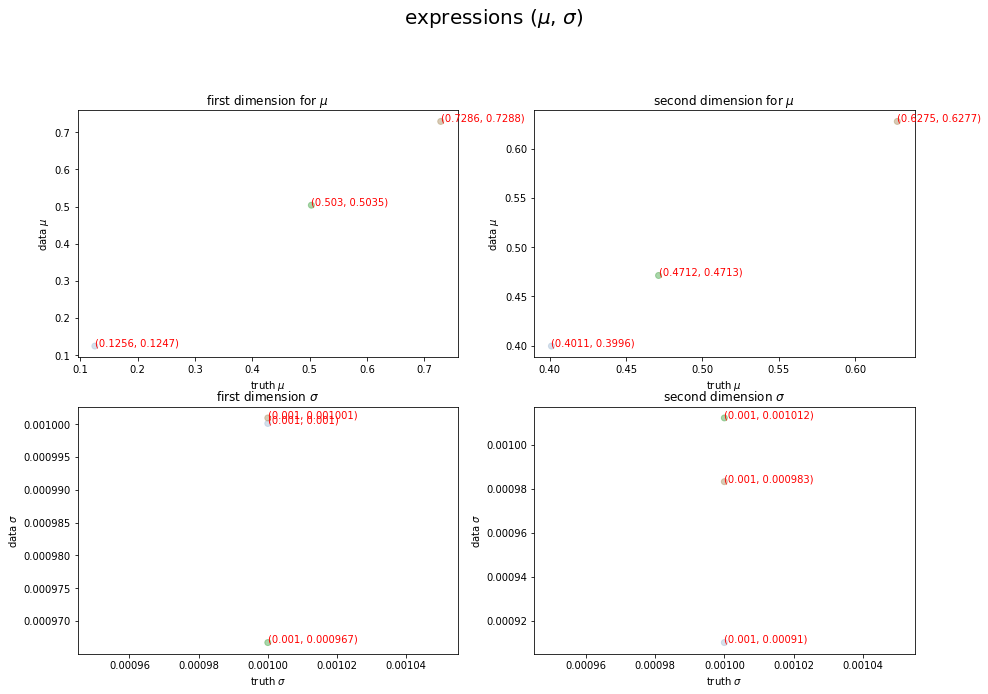

In [ ]:
mu_truth = theta0[0]

fig, axs = plt.subplots(2, 2, figsize=[15,10])

plt.text(x=0.51, y=1, s="expressions ($\mu$, $\sigma$)", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(truth=mu_truth[:,0], data=mu_data[:,0]))
df['cluster'] = range(nc)
axs[0,0].scatter(df['truth'], df['data'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0,0].set_xlabel("truth $\mu$")
axs[0,0].set_ylabel("data $\mu$")
axs[0,0].set_title("first dimension for $\mu$")
for a, b in zip(mu_truth[:,0], mu_data[:,0]): 
  axs[0,0].text(a, b, "({}, {})".format(np.round(a, 4), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(truth=mu_truth[:,1], data=mu_data[:,1]))
df['cluster'] = range(nc)
axs[0,1].scatter(df['truth'], df['data'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0,1].set_xlabel("truth $\mu$")
axs[0,1].set_ylabel("data $\mu$")
axs[0,1].set_title("second dimension for $\mu$")
for a, b in zip(mu_truth[:,1], mu_data[:,1]): 
  axs[0,1].text(a, b, "({}, {})".format(np.round(a, 4), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(truth=np.repeat(0.001, nc), data=sigma_data[:,0]))
df['cluster'] = range(nc)
axs[1,0].scatter(df['truth'], df['data'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1,0].set_xlabel("truth $\sigma$")
axs[1,0].set_ylabel("data $\sigma$")
axs[1,0].set_title("first dimension $\sigma$")
for a, b in zip(np.repeat(0.001, nc), sigma_data[:,0]): 
  axs[1,0].text(a, b, "({}, {})".format(np.round(a, 6), np.str(np.round(np.array(b), 6))), color = 'red')

df = pd.DataFrame(dict(truth=np.repeat(0.001, nc), data=sigma_data[:,1]))
df['cluster'] = range(nc)
axs[1,1].scatter(df['truth'], df['data'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1,1].set_xlabel("truth $\sigma$")
axs[1,1].set_ylabel("data $\sigma$")
axs[1,1].set_title("second dimension $\sigma$")
for a, b in zip(np.repeat(0.001, nc), sigma_data[:,1]): 
  axs[1,1].text(a, b, "({}, {})".format(np.round(a, 6), np.str(np.round(np.array(b), 6))), color = 'red')

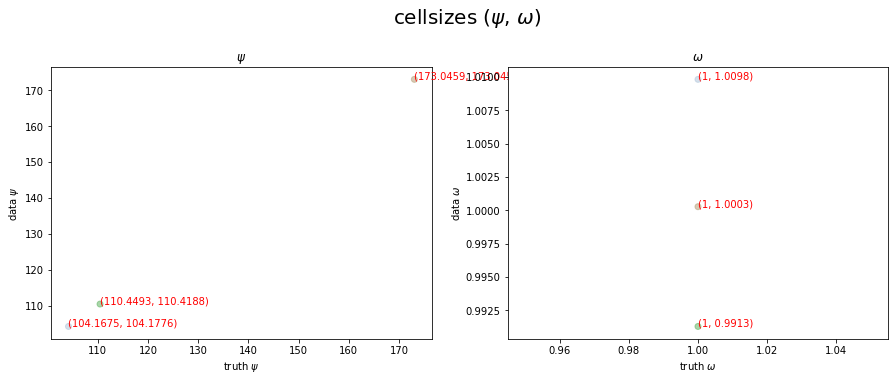

In [ ]:
psi_truth = theta0[2]

fig, axs = plt.subplots(1, 2, figsize=[15,5])

plt.text(x=0.51, y=1, s="cellsizes ($\psi$, $\omega$)", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(truth=psi_truth, data=psi_data))
df['cluster'] = range(nc)
axs[0].scatter(df['truth'], df['data'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel("truth $\psi$")
axs[0].set_ylabel("data $\psi$")
axs[0].set_title("$\psi$")
for a, b in zip(psi_truth, psi_data): 
  axs[0].text(a, b, "({}, {})".format(np.round(a, 4), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(truth=np.repeat(1, nc), data=omega_data))
df['cluster'] = range(nc)
axs[1].scatter(df['truth'], df['data'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel("truth $\omega$")
axs[1].set_ylabel("data $\omega$")
axs[1].set_title("$\omega$")
for a, b in zip(df['truth'], df['data']): 
  axs[1].text(a, b, "({}, {})".format(np.round(a, 4), np.str(np.round(np.array(b), 4))), color = 'red')

In [ ]:
pi_data = np.zeros(nc)
tau_data = np.zeros(int((nc * nc - nc)/2 + nc))
for j in range(nc):
  pi_data[j] = sum( XX[:,-1] == (j + len(tau_data)) )/XX.shape[0]

for j in range(len(tau_data)):
  tau_data[j] = sum( XX[:,-1] == j )/XX.shape[0]

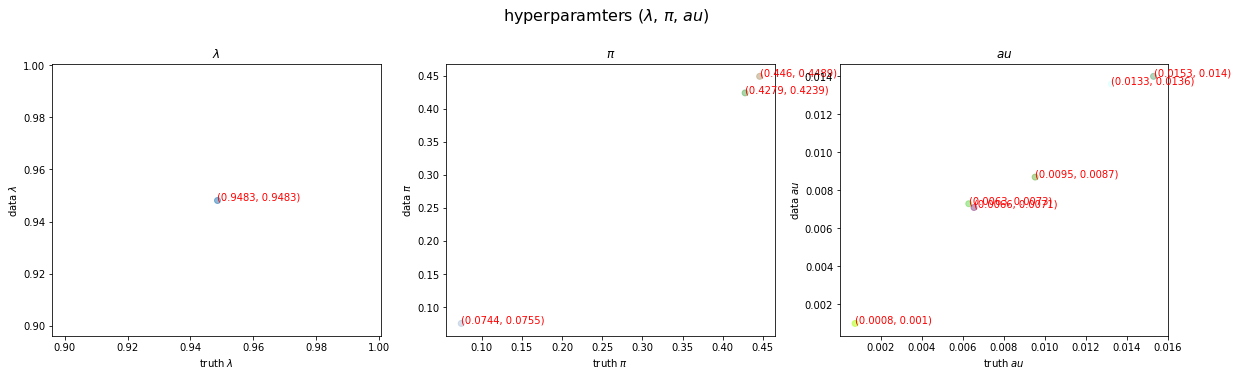

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=[20,5])

plt.text(x=0.51, y=1, s="hyperparamters ($\lambda$, $\pi$, $\tau$)", fontsize=16, ha="center", transform=fig.transFigure)

axs[0].scatter(theta1[0], sum(XX[:,3] == 0)/XX.shape[0], alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel("truth $\lambda$")
axs[0].set_ylabel("data $\lambda$")
axs[0].set_title("$\lambda$")
axs[0].text(theta1[0], np.array(sum(XX[:,3] == 0)/XX.shape[0]), "({}, {})".format(np.str(np.round(theta1[0], 4)), np.str(np.round(np.array(sum(XX[:,3] == 0)/XX.shape[0]), 4))), color = 'red')

df = pd.DataFrame(dict(truth=theta1[0] * theta1[1], data=pi_data))
df['cluster'] = range(nc)
axs[1].scatter(df['truth'], df['data'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel("truth $\pi$")
axs[1].set_ylabel("data $\pi$")
axs[1].set_title("$\pi$")
for a, b in zip(theta1[0] * theta1[1], pi_data): 
  axs[1].text(a, b, "({}, {})".format(np.round(a, 4), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(truth=(1-theta1[0]) * theta1[2], data=tau_data))
df['cluster'] = range(nc, nc + len(tau_data))
axs[2].scatter(df['truth'], df['data'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_xlabel("truth $\tau$")
axs[2].set_ylabel('data $\tau$')
axs[2].set_title("$\tau$")
for a, b in zip((1-theta1[0]) * theta1[2], tau_data): 
  axs[2].text(a, b, "({}, {})".format(np.round(a, 4), np.str(np.round(np.array(b), 4))), color = 'red')

**Evaluating initialization values**

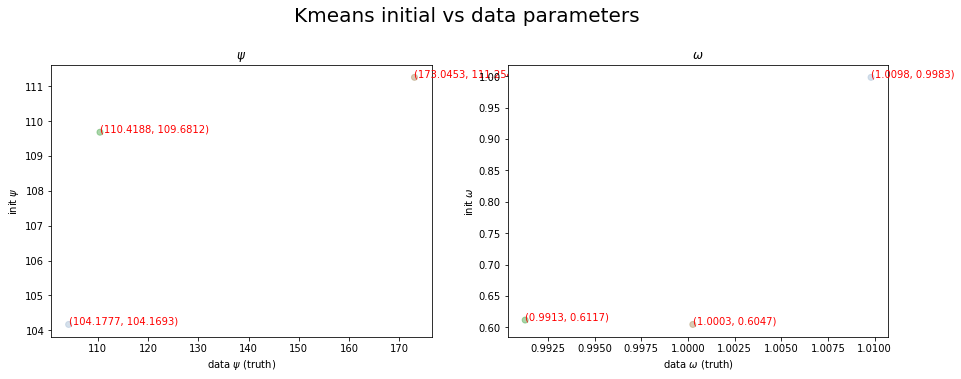

In [ ]:
psi_init = inits[0][3][0]
omega_init = inits[0][3][1]

fig, axs = plt.subplots(1, 2, figsize=[15,5])

plt.text(x=0.51, y=1, s="{}".format("Kmeans initial vs data parameters"), fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(data=psi_data, init=psi_init))
df['cluster'] = range(nc)
axs[0].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel("data $\psi$ (truth)")
axs[0].set_ylabel("init $\psi$")
axs[0].set_title("$\psi$")
for a, b in zip(df['data'], df['init']): 
  axs[0].text(a, b, "({}, {})".format(np.str(np.round(a, 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(init=omega_init, data=omega_data))
df['cluster'] = range(nc)
axs[1].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel("data $\omega$ (truth)")
axs[1].set_ylabel("init $\omega$")
axs[1].set_title("$\omega$")
for a, b in zip(df['data'], df['init']): 
  axs[1].text(a, b, "({}, {})".format(np.str(np.round(a, 4)), np.str(np.round(np.array(b), 4))), color = 'red')

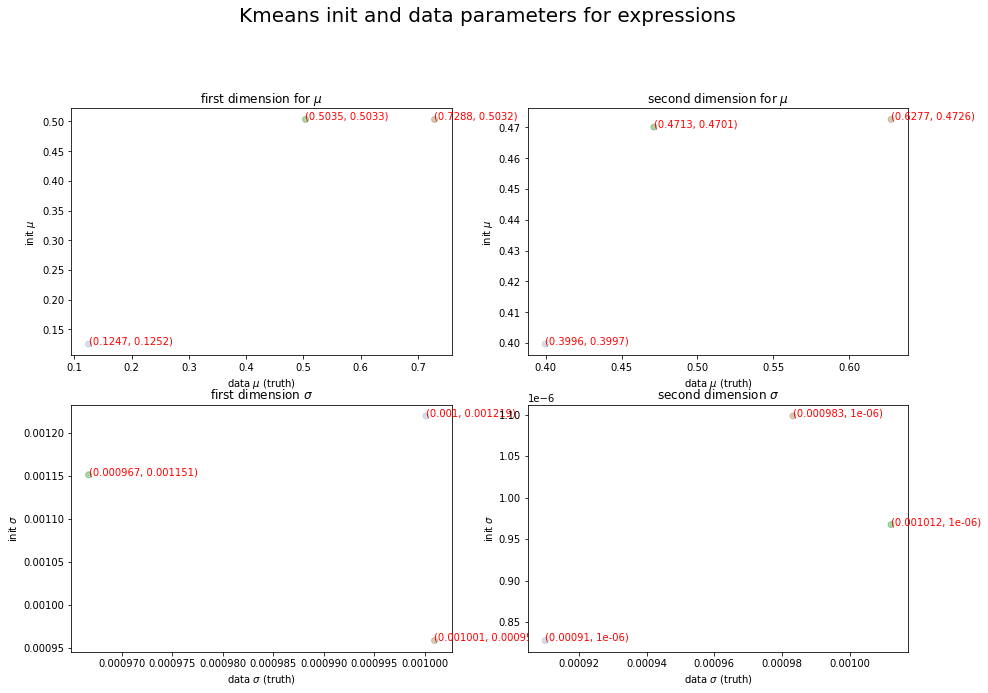

In [ ]:
#return score, [lambda_d0, pi, tau], [gpsi, gomega, gmu, gsigma], [psi, omega, mu, sigma]

mu_init = inits[0][3][2]
sigma_init = inits[0][3][3]

fig, axs = plt.subplots(2, 2, figsize=[15,10])

plt.text(x=0.51, y=1, s="Kmeans init and data parameters for expressions", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(init=mu_init[:,0], data=mu_data[:,0]))
df['cluster'] = range(nc)
axs[0,0].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0,0].set_ylabel("init $\mu$")
axs[0,0].set_xlabel("data $\mu$ (truth)")
axs[0,0].set_title("first dimension for $\mu$")
for a, b in zip(df['data'], df['init']): 
  axs[0,0].text(a, b, "({}, {})".format(np.str(np.round(a, 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(init=mu_init[:,1], data=mu_data[:,1]))
df['cluster'] = range(nc)
axs[0,1].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0,1].set_ylabel("init $\mu$")
axs[0,1].set_xlabel("data $\mu$ (truth)")
axs[0,1].set_title("second dimension for $\mu$")
for a, b in zip(df['data'], df['init']): 
  axs[0,1].text(a, b, "({}, {})".format(np.str(np.round(a, 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(init=sigma_init[:,0], data=sigma_data[:,0]))
df['cluster'] = range(nc)
axs[1,0].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1,0].set_ylabel("init $\sigma$")
axs[1,0].set_xlabel("data $\sigma$ (truth)")
axs[1,0].set_title("first dimension $\sigma$")
for a, b in zip(df['data'], df['init']): 
  axs[1,0].text(a, b, "({}, {})".format(np.str(np.round(a, 6)), np.str(np.round(np.array(b), 6))), color = 'red')

df = pd.DataFrame(dict(init=sigma_init[:,1] ** 2, data=sigma_data[:,1]))
df['cluster'] = range(nc)
axs[1,1].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1,1].set_ylabel("init $\sigma$")
axs[1,1].set_xlabel("data $\sigma$ (truth)")
axs[1,1].set_title("second dimension $\sigma$")
for a, b in zip(df['data'], df['init']): 
  axs[1,1].text(a, b, "({}, {})".format(np.str(np.round(a, 6)), np.str(np.round(np.array(b), 6))), color = 'red')

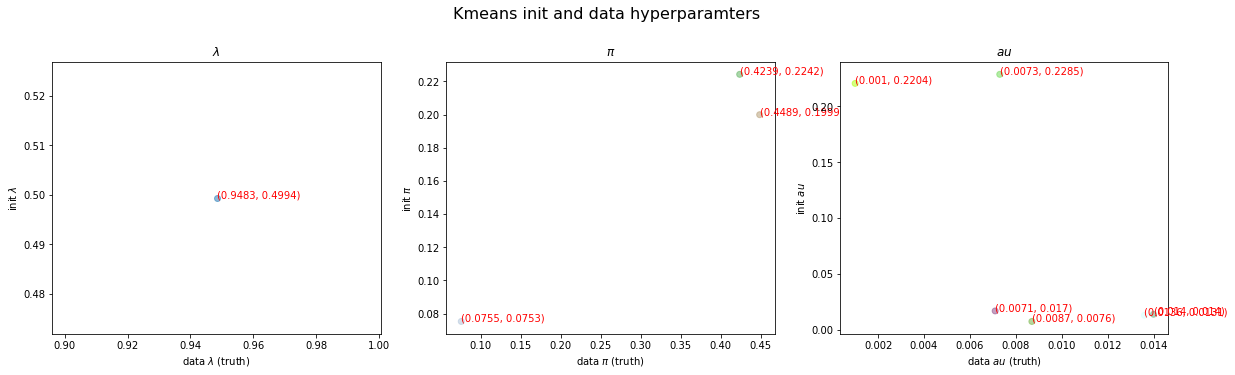

In [ ]:
lambda_init = inits[0][1][0]
pi_init = inits[0][1][1]
tau_init = inits[0][1][2].reshape(1,nc*nc)

fig, axs = plt.subplots(1, 3, figsize=[20,5])

plt.text(x=0.51, y=1, s="Kmeans init and data hyperparamters", fontsize=16, ha="center", transform=fig.transFigure)

axs[0].scatter(sum(XX[:,3] == 0)/XX.shape[0], lambda_init, alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_ylabel("init $\lambda$")
axs[0].set_xlabel("data $\lambda$ (truth)")
axs[0].set_title("$\lambda$")
axs[0].text(sum(XX[:,3] == 0)/XX.shape[0], lambda_init, "({}, {})".format(np.str(np.round(np.array(sum(XX[:,3] == 0)/XX.shape[0]), 4)), 
                                                                          np.str(np.round(np.array(lambda_init), 4))), color = 'red')

df = pd.DataFrame(dict(init=pi_init, data=pi_data))
df['cluster'] = range(nc)
axs[1].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_ylabel("init $\pi$")
axs[1].set_xlabel("data $\pi$ (truth)")
axs[1].set_title("$\pi$")
for a, b in zip(df['data'], df['init']): 
  axs[1].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(init=tau_init[~torch.isnan(tau_init)], data=tau_data))
df['cluster'] = range(nc, nc + len(tau_data))
axs[2].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_ylabel("init $\tau$")
axs[2].set_xlabel('data $\tau$ (truth)')
axs[2].set_title("$\tau$")
for a, b in zip(df['data'], df['init']): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

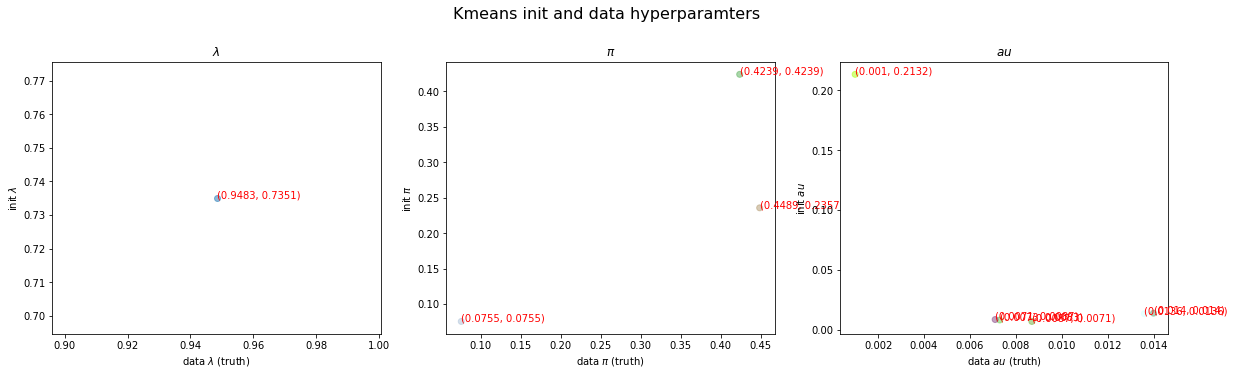

In [ ]:
lambda_init = inits[1][1][0]
pi_init = inits[1][1][1]
tau_init = inits[1][1][2].reshape(1,nc*nc)

fig, axs = plt.subplots(1, 3, figsize=[20,5])

plt.text(x=0.51, y=1, s="Kmeans init and data hyperparamters", fontsize=16, ha="center", transform=fig.transFigure)

axs[0].scatter(sum(XX[:,3] == 0)/XX.shape[0], lambda_init, alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_ylabel("init $\lambda$")
axs[0].set_xlabel("data $\lambda$ (truth)")
axs[0].set_title("$\lambda$")
axs[0].text(sum(XX[:,3] == 0)/XX.shape[0], lambda_init, "({}, {})".format(np.str(np.round(np.array(sum(XX[:,3] == 0)/XX.shape[0]), 4)), 
                                                                          np.str(np.round(np.array(lambda_init), 4))), color = 'red')

df = pd.DataFrame(dict(init=pi_init, data=pi_data))
df['cluster'] = range(nc)
axs[1].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_ylabel("init $\pi$")
axs[1].set_xlabel("data $\pi$ (truth)")
axs[1].set_title("$\pi$")
for a, b in zip(df['data'], df['init']): 
  axs[1].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(init=tau_init[~torch.isnan(tau_init)], data=tau_data))
df['cluster'] = range(nc, nc + len(tau_data))
axs[2].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_ylabel("init $\tau$")
axs[2].set_xlabel('data $\tau$ (truth)')
axs[2].set_title("$\tau$")
for a, b in zip(df['data'], df['init']): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

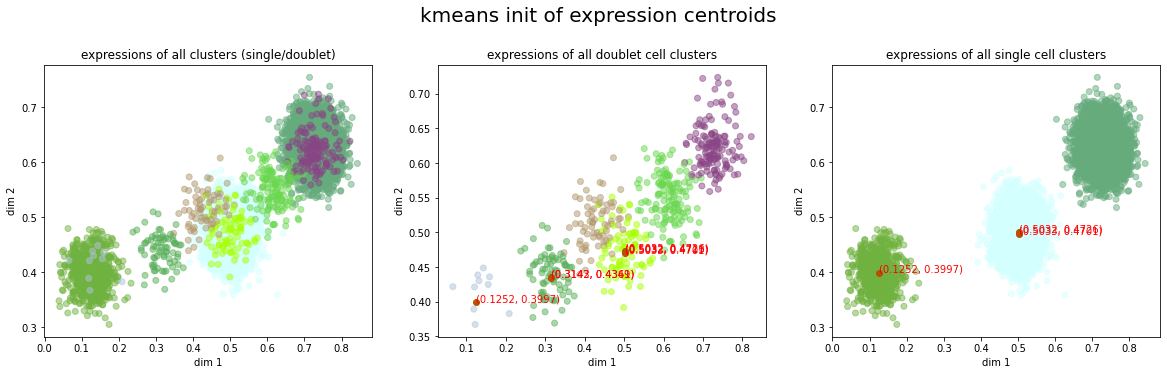

In [ ]:
#return score, [lambda_d0, pi, tau], [gpsi, gomega, gmu, gsigma], [psi, omega, mu, sigma]

init_theta0 = inits[0][3][2]
single_centroids = init_theta0 

fig, axs = plt.subplots(1, 3, figsize=[20,5])

#plt.suptitle("ground truth expressions") # or plt.suptitle('Main title')
plt.text(x=0.51, y=1, s="kmeans init of expression centroids", fontsize=20, ha="center", transform=fig.transFigure)
#plt.figtext(.5,.8,'Humidity',fontsize=30,ha='center')

df = pd.DataFrame(dict(f=XX[:, 0], s=XX[:, 1], l=XX[:, -1]))
axs[0].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel('dim 1')
axs[0].set_ylabel('dim 2')
#axs[0].set_ylim(-0.1, 1)
axs[0].set_title('expressions of all clusters (single/doublet)')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 1, 0], s=XX[XX[:, 3] == 1, 1], l=XX[XX[:, 3] == 1, -1]))
axs[1].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel('dim 1')
axs[1].set_ylabel('dim 2')
#axs[1].set_ylim(-0.1, 1)
axs[1].set_title('expressions of all doublet cell clusters')
#for j in range(init_theta0.shape[0]):
#  for k in range(init_theta0.shape[0]):
#    if j >= k:
#      cs = (init_theta0[j] + init_theta0[k])/2
#      axs[1].plot(cs[0], cs[1], "or", color = colors_list[100])

doublet_centroids = np.zeros((nc, nc, X.shape[1]))
for j in range(init_theta0.shape[0]):
  for k in range(init_theta0.shape[0]):
    if k >= j:
      doublet_centroids[j,k] = (init_theta0[j] + init_theta0[k])/2
      axs[1].plot(doublet_centroids[j,k][0], doublet_centroids[j,k][1], "or", color = colors_list[100])
      axs[1].text(doublet_centroids[j,k][0], doublet_centroids[j,k][1], "({}, {})".format(np.str(np.round(np.array(doublet_centroids[j,k][0]), 4)), np.str(np.round(np.array(doublet_centroids[j,k][1]), 4))), color = 'red')
    else:
      doublet_centroids[j,k] = float('NaN')  

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 0, 0], s=XX[XX[:, 3] == 0, 1], l=XX[XX[:, 3] == 0, -1]))
axs[2].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_xlabel('dim 1')
axs[2].set_ylabel('dim 2')
#axs[2].set_ylim(-0.1, 1)
axs[2].set_title('expressions of all single cell clusters')
axs[2].plot(init_theta0[:,0], init_theta0[:,1], "or", color = colors_list[100])
for a, b in zip(init_theta0[:,0], init_theta0[:,1]): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')
plt.show()

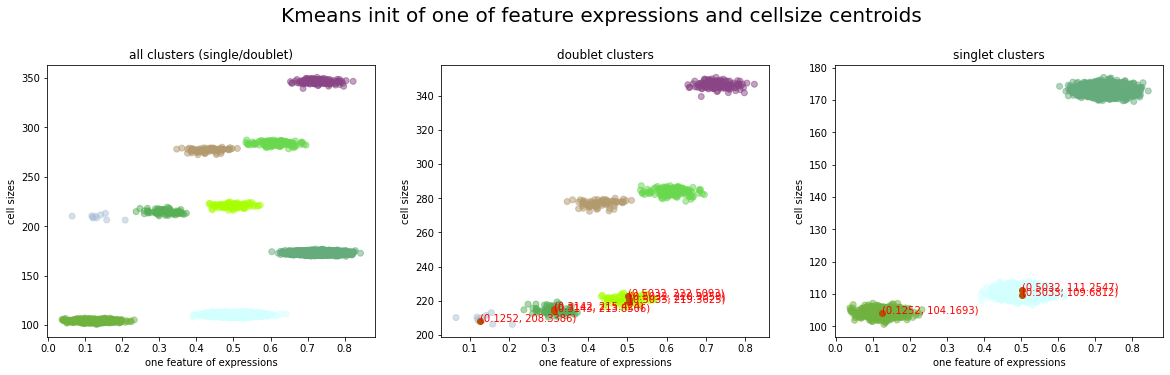

In [ ]:
#return score, [lambda_d0, pi, tau], [gpsi, gomega, gmu, gsigma], [psi, omega, mu, sigma]

fig, axs = plt.subplots(1, 3, figsize=[20,5])

plt.text(x=0.51, y=1, s="Kmeans init of one of feature expressions and cellsize centroids", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(f=XX[:, 0], s=XX[:, 2], l=XX[:, -1]))
axs[0].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel('one feature of expressions')
axs[0].set_ylabel('cell sizes')
#axs[0].set_ylim(-0.1, 1)
axs[0].set_title('all clusters (single/doublet)')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 1, 0], s=XX[XX[:, 3] == 1, 2], l=XX[XX[:, 3] == 1, -1]))
axs[1].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel('one feature of expressions')
axs[1].set_ylabel('cell sizes')
axs[1].set_title('doublet clusters')
for j in range(init_theta0.shape[0]):
  for k in range(init_theta0.shape[0]):
    if k >= j:
      axs[1].plot(doublet_centroids[j,k][0], inits[0][3][0][j] + inits[0][3][0][k], "or", color = colors_list[100])
      axs[1].text(doublet_centroids[j,k][0], inits[0][3][0][j] + inits[0][3][0][k], 
                  "({}, {})".format(np.str(np.round(np.array(doublet_centroids[j,k][0]), 4)), 
                                    np.str(np.round(np.array(inits[0][3][0][j] + inits[0][3][0][k]), 4))), color = 'red') 

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 0, 0], s=XX[XX[:, 3] == 0, 2], l=XX[XX[:, 3] == 0, -1]))
axs[2].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_xlabel('one feature of expressions')
axs[2].set_ylabel('cell sizes')
axs[2].set_title('singlet clusters')
axs[2].plot(init_theta0[:,0], inits[0][3][0], "or", color = colors_list[100])
for a, b in zip(init_theta0[:,0], inits[0][3][0]): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')
plt.show()

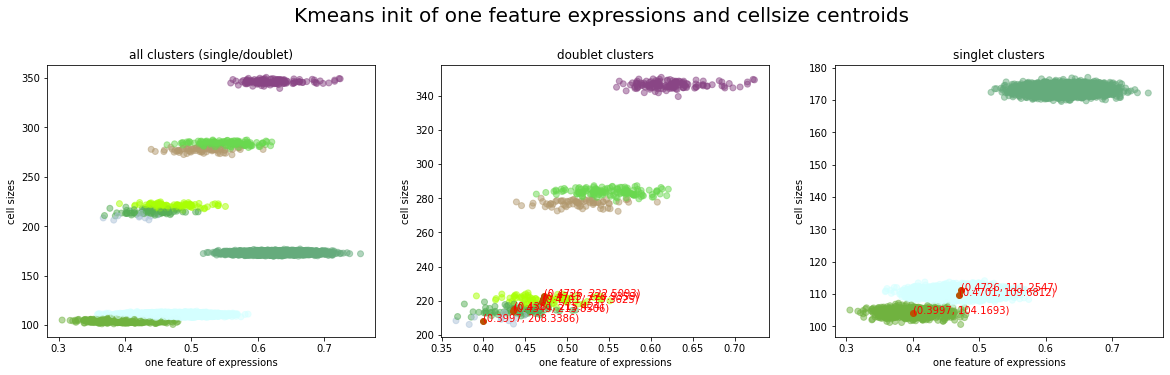

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=[20,5])

plt.text(x=0.51, y=1, s="Kmeans init of one feature expressions and cellsize centroids", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(f=XX[:, 1], s=XX[:, 2], l=XX[:, -1]))
axs[0].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel('one feature of expressions')
axs[0].set_ylabel('cell sizes')
#axs[0].set_ylim(-0.1, 1)
axs[0].set_title('all clusters (single/doublet)')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 1, 1], s=XX[XX[:, 3] == 1, 2], l=XX[XX[:, 3] == 1, -1]))
axs[1].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel('one feature of expressions')
axs[1].set_ylabel('cell sizes')
axs[1].set_title('doublet clusters')
for j in range(init_theta0.shape[0]):
  for k in range(init_theta0.shape[0]):
    if k >= j:
      axs[1].plot(doublet_centroids[j,k][1], inits[0][3][0][j] + inits[0][3][0][k], "or", color = colors_list[100])
      axs[1].text(doublet_centroids[j,k][1], inits[0][3][0][j] + inits[0][3][0][k], 
                  "({}, {})".format(np.str(np.round(np.array(doublet_centroids[j,k][1]), 4)), 
                                    np.str(np.round(np.array(inits[0][3][0][j] + inits[0][3][0][k]), 4))), color = 'red') 

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 0, 1], s=XX[XX[:, 3] == 0, 2], l=XX[XX[:, 3] == 0, -1]))
axs[2].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_xlabel('one feature of expressions')
axs[2].set_ylabel('cell sizes')
axs[2].set_title('singlet clusters')
axs[2].plot(init_theta0[:,1], inits[0][3][0], "or", color = colors_list[100])
for a, b in zip(init_theta0[:,1], inits[0][3][0]): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')
plt.show()

**Evauluating Model**

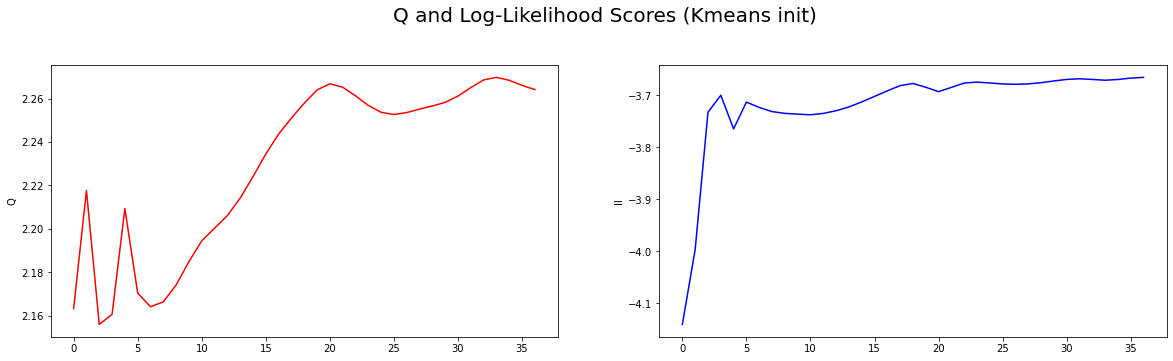

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=[20,5])

plt.text(x=0.51, y=1, s="Q and Log-Likelihood Scores (Kmeans init)", fontsize=20, ha="center", transform=fig.transFigure)

axs[0].set_ylabel('Q')
axs[1].set_ylabel('ll')
  
## Q
axs[0].plot(fit_kms[2], 'r')
    
## L
axs[1].plot(fit_kms[1], 'b')
fig.show()

In [ ]:
fit_kms[3].detach() ##AIC

tensor(73.3313)

In [ ]:
fit_kms[4].detach() ##BIC

tensor(311.2725)

In [ ]:
#return n_clusters, ls[1:], qs[1:], aic, bic, pi_d0, n_c, pi_c, pi_d1, n_cc, pi_cc, parameters, rdz, rdg

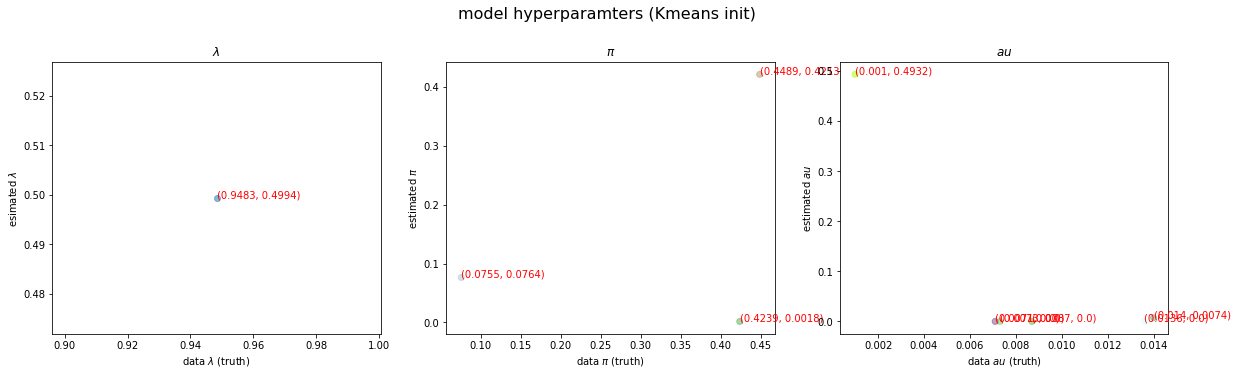

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=[20,5])

plt.text(x=0.51, y=1, s="model hyperparamters (Kmeans init)", fontsize=16, ha="center", transform=fig.transFigure)

axs[0].scatter(sum(XX[:,3] == 0)/XX.shape[0], fit_kms[5], alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_ylabel("esimated $\lambda$")
axs[0].set_xlabel("data $\lambda$ (truth)")
axs[0].set_title("$\lambda$")
axs[0].text(sum(XX[:,3] == 0)/XX.shape[0], fit_kms[5], "({}, {})".format(np.str(np.round(np.array(sum(XX[:,3] == 0)/XX.shape[0]), 4)), 
                                                                     np.str(np.round(np.array(fit_kms[5]), 4))), color = 'red')

df = pd.DataFrame(dict(estimated=fit_kms[7], data=pi_data))
df['cluster'] = range(nc)
axs[1].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_ylabel("estimated $\pi$")
axs[1].set_xlabel("data $\pi$ (truth)")
axs[1].set_title("$\pi$")
for a, b in zip(df['data'], df['estimated']): 
  axs[1].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

tau_estimated = fit_kms[10].reshape(1,nc*nc)

df = pd.DataFrame(dict(estimated=tau_estimated[~torch.isnan(tau_estimated)], data=tau_data))
df['cluster'] = range(nc, nc + len(tau_data))
axs[2].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_ylabel("estimated $\tau$")
axs[2].set_xlabel('data $\tau$ (truth)')
axs[2].set_title("$\tau$")
for a, b in zip(df['data'], df['estimated']): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

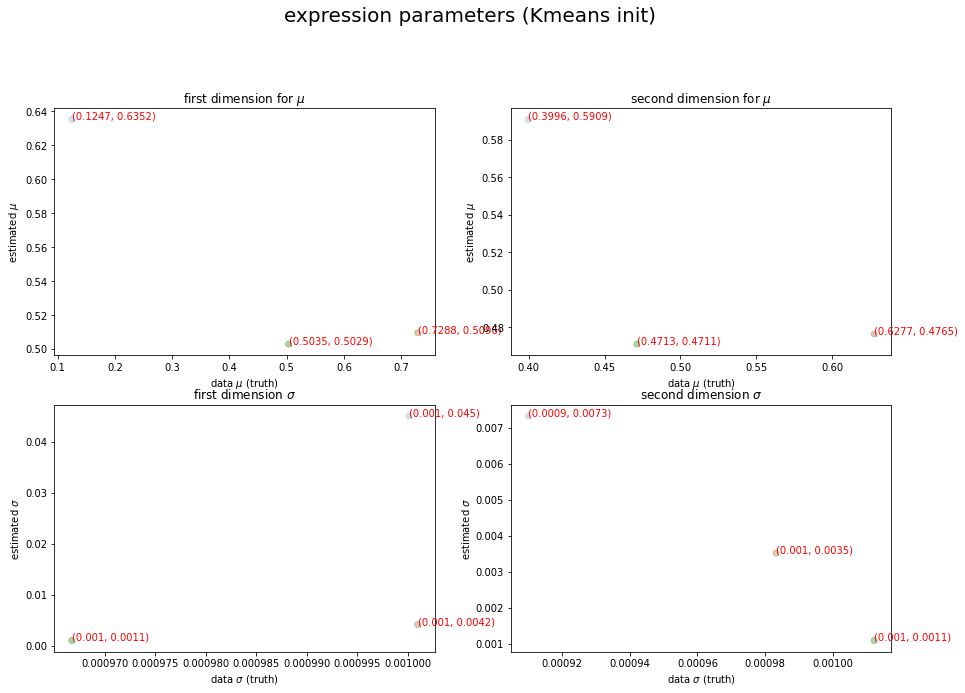

In [ ]:
mu_estimated = fit_kms[11][2].detach().numpy()
sigma_estimated = fit_kms[11][3].detach().numpy()

fig, axs = plt.subplots(2, 2, figsize=[15,10])

plt.text(x=0.51, y=1, s="expression parameters (Kmeans init)", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(estimated=mu_estimated[:,0], data=mu_data[:,0]))
df['cluster'] = range(nc)
axs[0,0].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0,0].set_ylabel("estimated $\mu$")
axs[0,0].set_xlabel("data $\mu$ (truth)")
axs[0,0].set_title("first dimension for $\mu$")
for a, b in zip(df['data'], df['estimated']): 
  axs[0,0].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(estimated=mu_estimated[:,1], data=mu_data[:,1]))
df['cluster'] = range(nc)
axs[0,1].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0,1].set_ylabel("estimated $\mu$")
axs[0,1].set_xlabel("data $\mu$ (truth)")
axs[0,1].set_title("second dimension for $\mu$")
for a, b in zip(df['data'], df['estimated']): 
  axs[0,1].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(estimated=sigma_estimated[:,0], data=sigma_data[:,0]))
df['cluster'] = range(nc)
axs[1,0].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1,0].set_ylabel("estimated $\sigma$")
axs[1,0].set_xlabel("data $\sigma$ (truth)")
axs[1,0].set_title("first dimension $\sigma$")
for a, b in zip(df['data'], df['estimated']): 
  axs[1,0].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(estimated=sigma_estimated[:,1], data=sigma_data[:,1]))
df['cluster'] = range(nc)
axs[1,1].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1,1].set_ylabel("estimated $\sigma$")
axs[1,1].set_xlabel("data $\sigma$ (truth)")
axs[1,1].set_title("second dimension $\sigma$")
for a, b in zip(df['data'], df['estimated']): 
  axs[1,1].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')


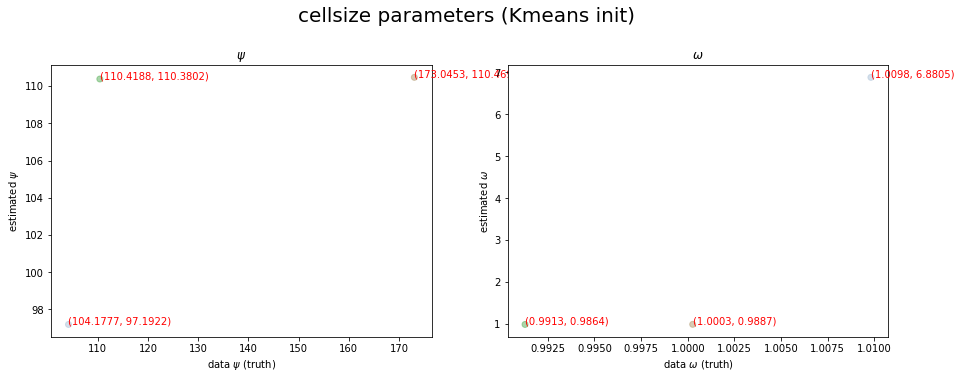

In [ ]:
psi_estimated = fit_kms[11][0].detach().numpy()
omega_estimated = fit_kms[11][1].detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=[15,5])

plt.text(x=0.51, y=1, s="cellsize parameters (Kmeans init)", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(estimated=psi_estimated, data=psi_data))
df['cluster'] = range(nc)
axs[0].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_ylabel("estimated $\psi$")
axs[0].set_xlabel("data $\psi$ (truth)")
axs[0].set_title("$\psi$")
for a, b in zip(df['data'], df['estimated']): 
  axs[0].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(estimated=omega_estimated, data=omega_data))
df['cluster'] = range(nc)
axs[1].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_ylabel("estimated $\omega$")
axs[1].set_xlabel("data $\omega$ (truth)")
axs[1].set_title("$\omega$")
for a, b in zip(df['data'], df['estimated']): 
  axs[1].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')


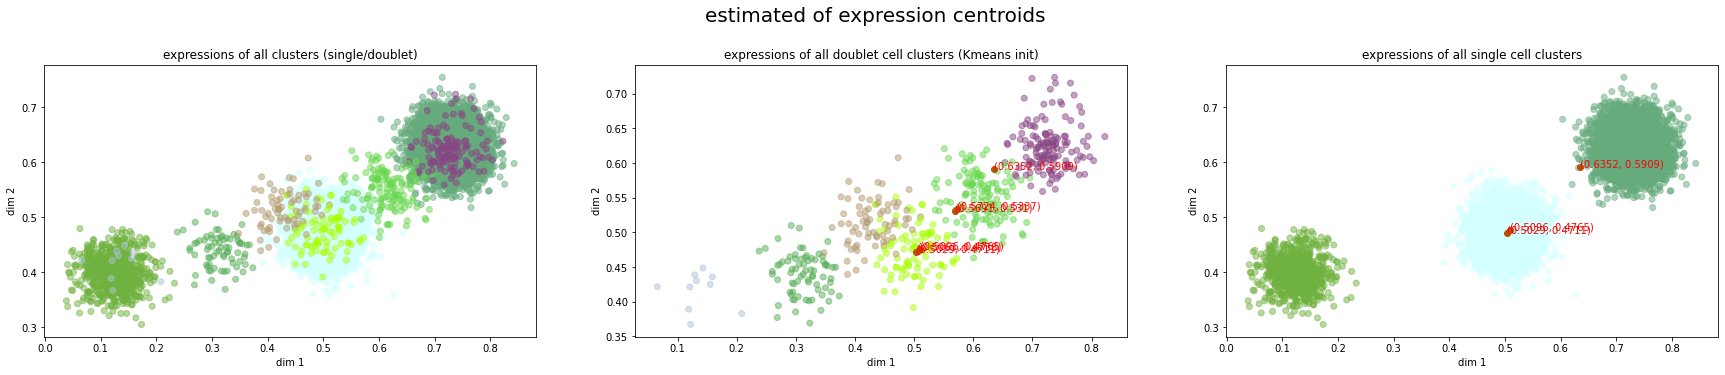

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=[30,5])

#plt.suptitle("ground truth expressions") # or plt.suptitle('Main title')
plt.text(x=0.51, y=1, s="estimated of expression centroids", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(f=XX[:, 0], s=XX[:, 1], l=XX[:, -1]))
axs[0].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel('dim 1')
axs[0].set_ylabel('dim 2')
#axs[0].set_ylim(0.0, 1.1)
axs[0].set_title('expressions of all clusters (single/doublet)')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 1, 0], s=XX[XX[:, 3] == 1, 1], l=XX[XX[:, 3] == 1, -1]))
axs[1].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel('dim 1')
axs[1].set_ylabel('dim 2')
#axs[1].set_ylim(0.0, 1.1)
axs[1].set_title('expressions of all doublet cell clusters (Kmeans init)')
#for j in range(init_theta0.shape[0]):
#  for k in range(init_theta0.shape[0]):
#    if j >= k:
#      cs = (init_theta0[j] + init_theta0[k])/2
#      axs[1].plot(cs[0], cs[1], "or", color = colors_list[100])

doublet_centroids = np.zeros((nc, nc, X.shape[1]))
for j in range(init_theta0.shape[0]):
  for k in range(init_theta0.shape[0]):
    if k >= j:
      doublet_centroids[j,k] = (mu_estimated[j] + mu_estimated[k])/2
      axs[1].plot(doublet_centroids[j,k][0], doublet_centroids[j,k][1], "or", color = colors_list[100])
      axs[1].text(doublet_centroids[j,k][0], doublet_centroids[j,k][1], "({}, {})".format(np.str(np.round(np.array(doublet_centroids[j,k][0]), 4)), np.str(np.round(np.array(doublet_centroids[j,k][1]), 4))), color = 'red')
    else:
      doublet_centroids[j,k] = float('NaN')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 0, 0], s=XX[XX[:, 3] == 0, 1], l=XX[XX[:, 3] == 0, -1]))
axs[2].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_xlabel('dim 1')
axs[2].set_ylabel('dim 2')
#axs[2].set_ylim(0.0, 1.1)
axs[2].set_title('expressions of all single cell clusters')
axs[2].plot(mu_estimated[:,0], mu_estimated[:,1], "or", color = colors_list[100])
for a, b in zip(mu_estimated[:,0], mu_estimated[:,1]): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

plt.show()

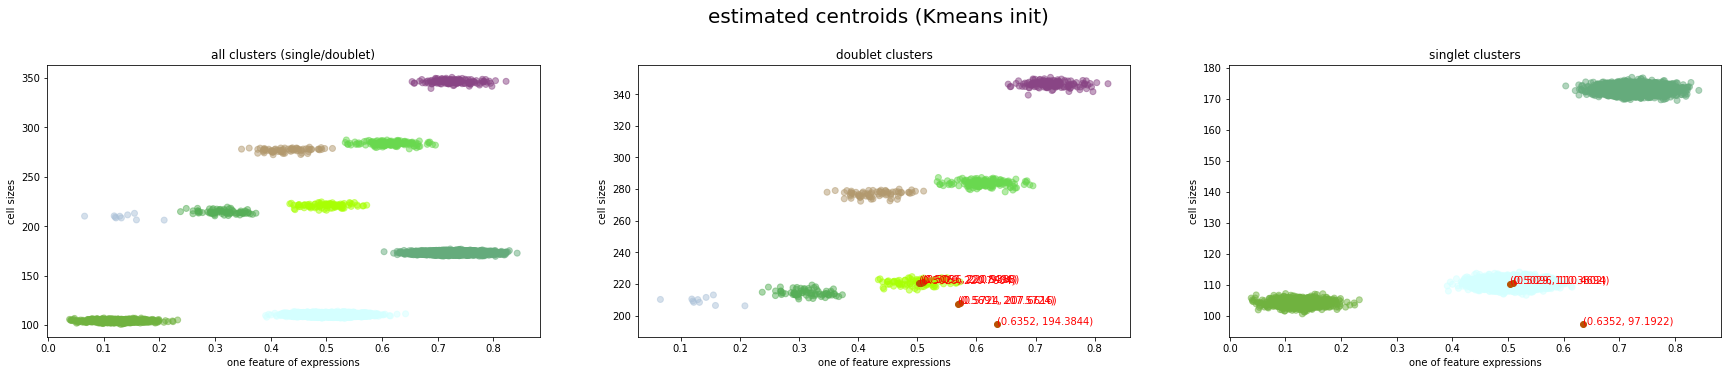

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=[30,5])

#plt.suptitle("ground truth expressions") # or plt.suptitle('Main title')
plt.text(x=0.51, y=1, s="estimated centroids (Kmeans init)", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(f=XX[:, 0], s=XX[:, 2], l=XX[:, -1]))
axs[0].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel('one feature of expressions')
axs[0].set_ylabel('cell sizes')
#axs[0].set_ylim(0.0, 1.1)
axs[0].set_title('all clusters (single/doublet)')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 1, 0], s=XX[XX[:, 3] == 1, 2], l=XX[XX[:, 3] == 1, -1]))
axs[1].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel('one of feature expressions')
axs[1].set_ylabel('cell sizes')
axs[1].set_title('doublet clusters')

estimated_doublet_centroids = np.zeros((nc, nc, X.shape[1]))
for j in range(init_theta0.shape[0]):
  for k in range(init_theta0.shape[0]):
    if k >= j:
      estimated_doublet_centroids[j,k] = (mu_estimated[j] + mu_estimated[k])/2
      axs[1].plot(estimated_doublet_centroids[j,k][0], psi_estimated[j] + psi_estimated[k] , "or", color = colors_list[100])
      axs[1].text(estimated_doublet_centroids[j,k][0], psi_estimated[j] + psi_estimated[k], 
                  "({}, {})".format(np.str(np.round(np.array(estimated_doublet_centroids[j,k][0]), 4)), 
                                    np.str(np.round(np.array(psi_estimated[j] + psi_estimated[k]), 4))), color = 'red')
    else:
      estimated_doublet_centroids[j,k] = float('NaN')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 0, 0], s=XX[XX[:, 3] == 0, 2], l=XX[XX[:, 3] == 0, -1]))
axs[2].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_xlabel('one of feature expressions')
axs[2].set_ylabel('cell sizes')
#axs[2].set_ylim(0.0, 1.1)
axs[2].set_title('singlet clusters')
axs[2].plot(mu_estimated[:,0], psi_estimated, "or", color = colors_list[100])
for a, b in zip(mu_estimated[:,0], psi_estimated): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

plt.show()

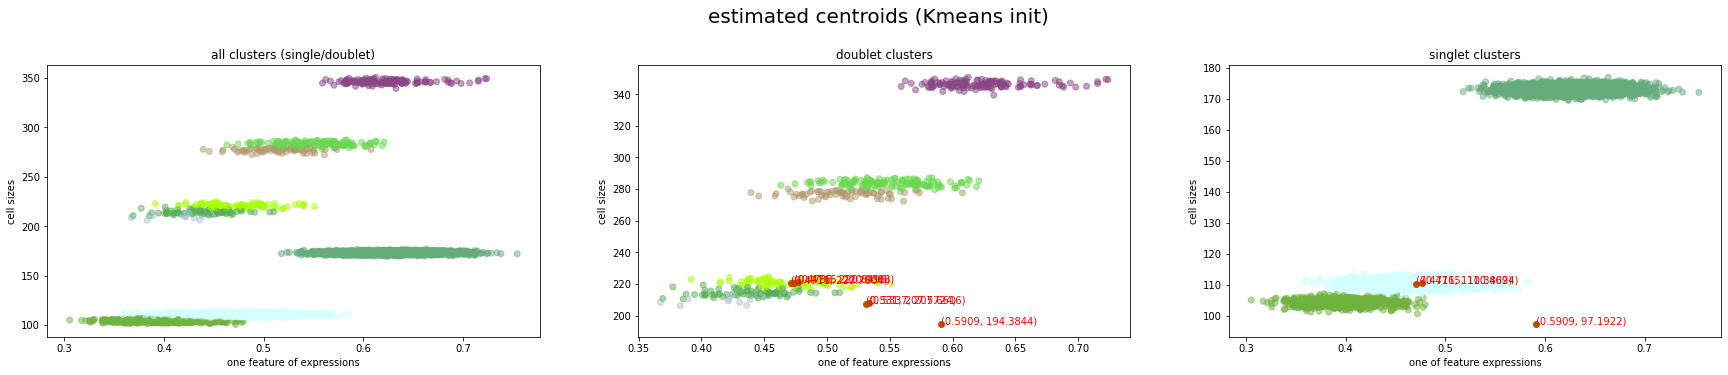

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=[30,5])

#plt.suptitle("ground truth expressions") # or plt.suptitle('Main title')
plt.text(x=0.51, y=1, s="estimated centroids (Kmeans init)", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(f=XX[:, 1], s=XX[:, 2], l=XX[:, -1]))
axs[0].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel('one feature of expressions')
axs[0].set_ylabel('cell sizes')
#axs[0].set_ylim(10, 360)
axs[0].set_title('all clusters (single/doublet)')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 1, 1], s=XX[XX[:, 3] == 1, 2], l=XX[XX[:, 3] == 1, -1]))
axs[1].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel('one of feature expressions')
axs[1].set_ylabel('cell sizes')
#axs[1].set_ylim(10, 360)
axs[1].set_title('doublet clusters')

estimated_doublet_centroids = np.zeros((nc, nc, X.shape[1]))
for j in range(init_theta0.shape[0]):
  for k in range(init_theta0.shape[0]):
    if k >= j:
      estimated_doublet_centroids[j,k] = (mu_estimated[j] + mu_estimated[k])/2
      axs[1].plot(estimated_doublet_centroids[j,k][1], psi_estimated[j] + psi_estimated[k] , "or", color = colors_list[100])
      axs[1].text(estimated_doublet_centroids[j,k][1], psi_estimated[j] + psi_estimated[k], 
                  "({}, {})".format(np.str(np.round(np.array(estimated_doublet_centroids[j,k][1]), 4)), 
                                    np.str(np.round(np.array(psi_estimated[j] + psi_estimated[k]), 4))), color = 'red')
    else:
      estimated_doublet_centroids[j,k] = float('NaN')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 0, 1], s=XX[XX[:, 3] == 0, 2], l=XX[XX[:, 3] == 0, -1]))
axs[2].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_xlabel('one of feature expressions')
axs[2].set_ylabel('cell sizes')
#axs[2].set_ylim(10, 360)
axs[2].set_title('singlet clusters')
axs[2].plot(mu_estimated[:,1], psi_estimated, "or", color = colors_list[100])
for a, b in zip(mu_estimated[:,1], psi_estimated): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

plt.show()

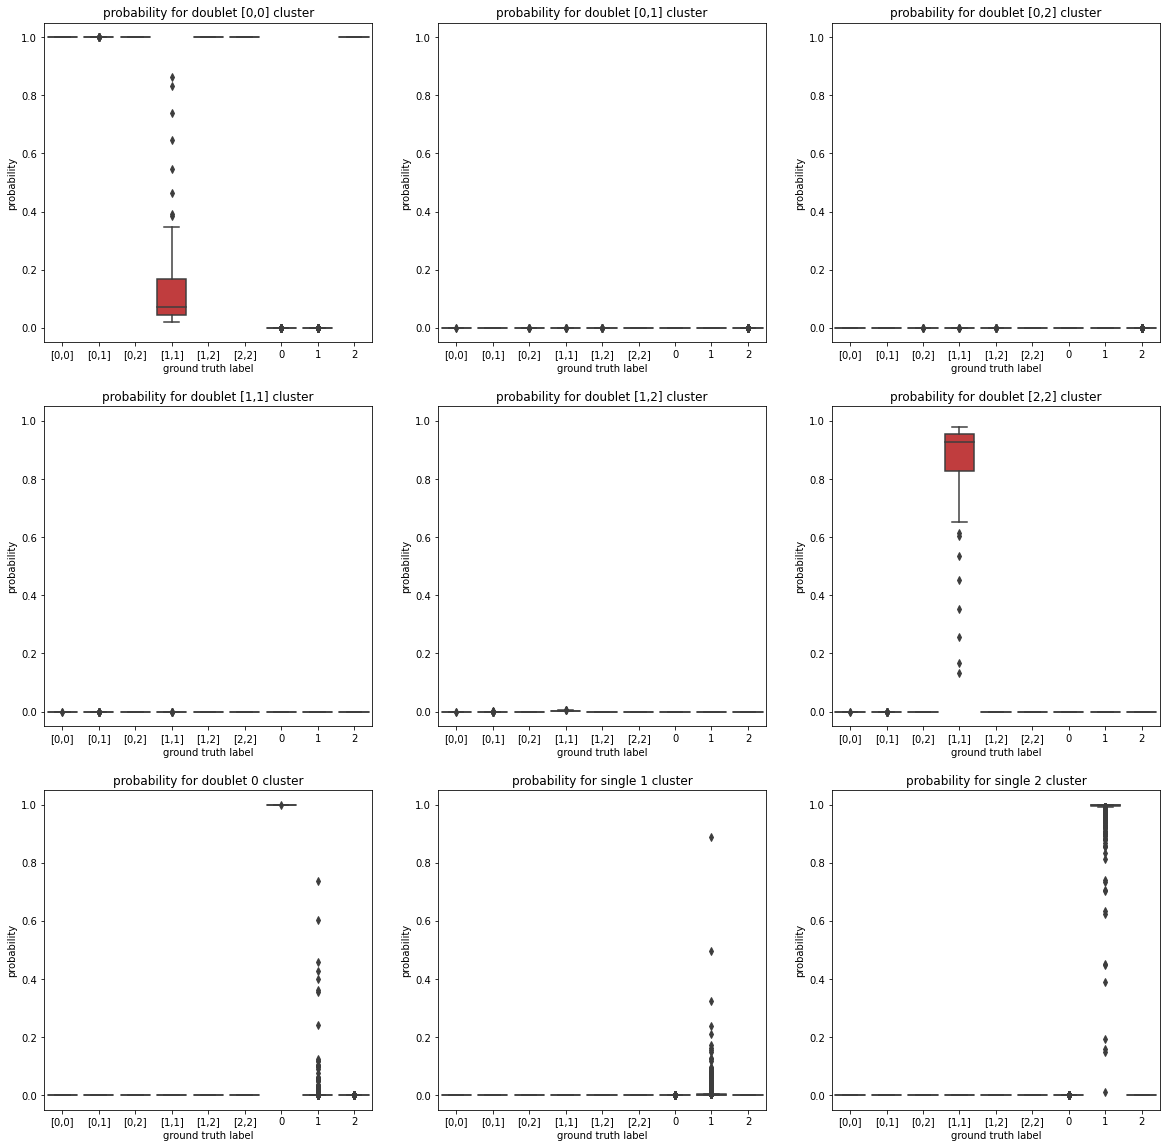

In [ ]:
## get string labels
ss = []
for j in range(init_theta0.shape[0]):
  for k in range(init_theta0.shape[0]):
    if k >= j:
      ss.append( "[{},{}]".format(j, k) )

for j in range(init_theta0.shape[0]):
  ss.append( "{}".format(j) )

n_clusters = nc
n_features = nf
n_obs = 10000

dps = fit_kms[13].reshape(n_obs, n_clusters * n_clusters)
prob = torch.hstack((dps[:,~torch.isnan(dps[0])], fit_kms[12]))

#ss = ['(0,0)','(0,1)','(0,2)','(1,1)','(1,2)','(2,2)','0','1','2']
import seaborn as sns

num_doublet_clusters = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
## cluster memberships compared to the truth assignments
plt.figure(figsize=[20,20])
count = 1
for i in range(len(ss)):
  ddd = np.vstack((np.array(XX[:,-1].numpy(), dtype=int), prob[:,i].detach().numpy())).T
  plt.subplot(n_clusters, n_clusters, count)
  ax = sns.boxplot(y=ddd[:,1], x=ddd[:,0].astype(int))
  ax.set(xlabel='ground truth label', ylabel= 'probability')
  ax.set_xticklabels(ss)
  ax.set_ylim(-0.05, 1.05)
  if i > num_doublet_clusters:
    ax.set_title("{} {} {}".format('probability for single', ss[i], "cluster"))
  else:
    ax.set_title("{} {} {}".format('probability for doublet', ss[i], "cluster"))
  count += 1
plt.show()
#plt.savefig('probsVtruth.png')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'pred label')

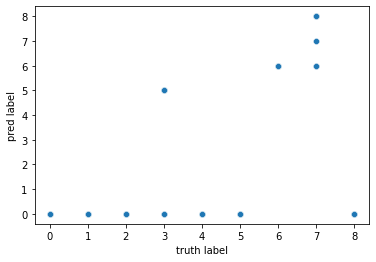

In [ ]:
  #plt.subplot(1, 1, 1)
  ax = sns.scatterplot(np.array(XX[:,-1].numpy(), dtype=int), torch.max(prob,1).indices)
  ax.set_xlabel('truth label')
  ax.set_ylabel('pred label')

In [ ]:
sum(np.array(XX[:,-1].numpy(), dtype=int) == np.array(torch.max(prob,1).indices))/n_obs ##truth vs pred

0.0767

torch.Size([10000, 2])
(10000, 2)


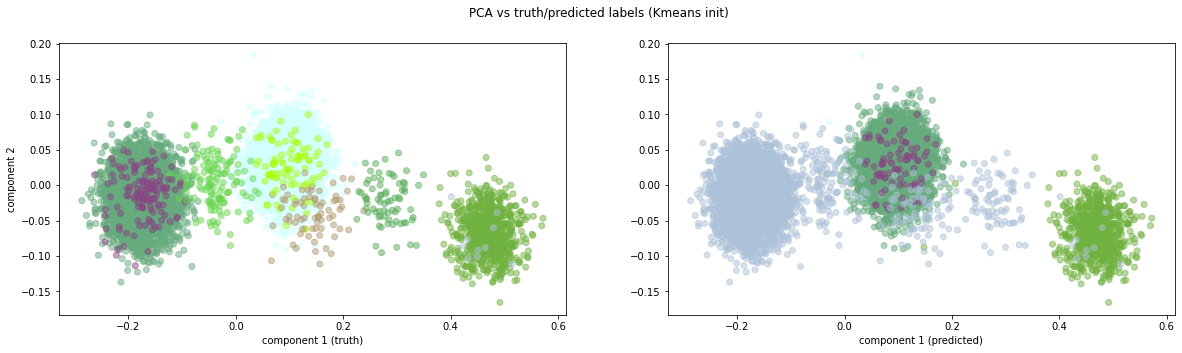

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)  # project from 20 to 2 dimensions
projected = pca.fit_transform(X)
print(X.shape)
print(projected.shape)

plt.figure(figsize=[20,5])

plt.suptitle("PCA vs truth/predicted labels (Kmeans init)") # or plt.suptitle('Main title')

df = pd.DataFrame(dict(f=projected[:, 0], s=projected[:, 1], l=np.array(XX[:,-1].detach().numpy().astype(int), dtype="int")))

plt.subplot(1, 2, 1)
ax = plt.scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (truth)')
ax = plt.ylabel('component 2')

df = pd.DataFrame(dict(f=projected[:, 0], s=projected[:, 1], l=np.array(torch.max(prob,1).indices, dtype="int")))

plt.subplot(1, 2, 2)
ax = plt.scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (predicted)')

(10000, 2)


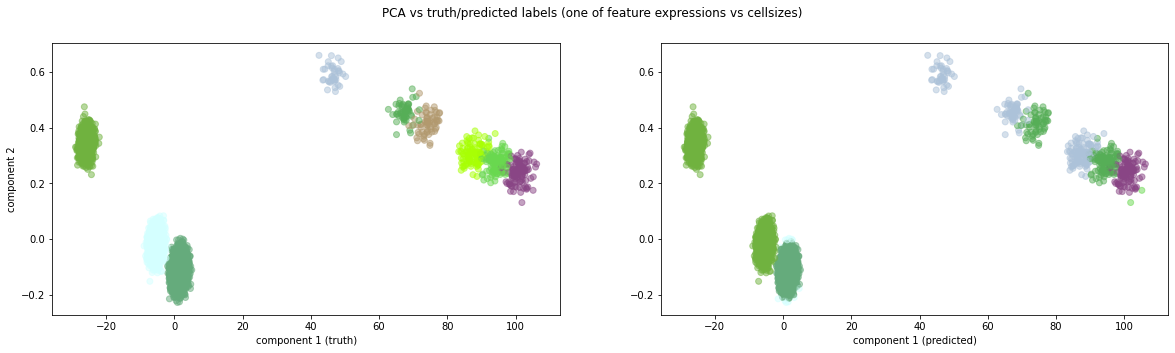

In [ ]:
pca = PCA(2)  # project from 20 to 2 dimensions
projected = pca.fit_transform(np.vstack((XX[:,0], XX[:,2])).T)
print(projected.shape)

df = pd.DataFrame(dict(f=projected[:, 0], s=projected[:, 1], l=np.array(XX[:,-1].detach().numpy().astype(int), dtype="int")))

plt.figure(figsize=[20,5])

plt.suptitle("PCA vs truth/predicted labels (Kmeans init)") # or plt.suptitle('Main title')

plt.subplot(1, 2, 1)
ax = plt.scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (truth)')
ax = plt.ylabel('component 2')

df = pd.DataFrame(dict(f=projected[:, 0], s=projected[:, 1], l=np.array(torch.max(prob,1).indices, dtype="int")))

plt.subplot(1, 2, 2)
ax = plt.scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (predicted)')

(10000, 2)


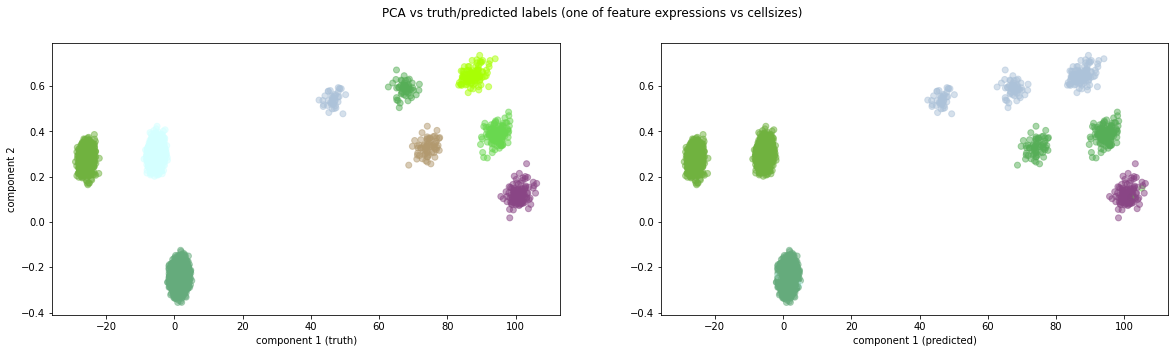

In [ ]:
pca = PCA(2)  # project from 20 to 2 dimensions
projected = pca.fit_transform(np.vstack((XX[:,1], XX[:,2])).T)
print(projected.shape)

df = pd.DataFrame(dict(f=projected[:, 0], s=projected[:, 1], l=np.array(XX[:,-1].detach().numpy().astype(int), dtype="int")))

plt.figure(figsize=[20,5])

plt.suptitle("PCA vs truth/predicted labels (Kmeans init)") # or plt.suptitle('Main title')

plt.subplot(1, 2, 1)
ax = plt.scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (truth)')
ax = plt.ylabel('component 2')

df = pd.DataFrame(dict(f=projected[:, 0], s=projected[:, 1], l=np.array(torch.max(prob,1).indices, dtype="int")))

plt.subplot(1, 2, 2)
ax = plt.scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (predicted)')

**Evaluating initialization (GMM init)**

In [ ]:
psi_init = inits[1][3][0]
omega_init = inits[1][3][1]

fig, axs = plt.subplots(1, 2, figsize=[15,5])

plt.text(x=0.51, y=1, s="{}".format("GMM initial vs data parameters"), fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(data=psi_data, init=psi_init))
df['cluster'] = range(nc)
axs[0].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel("data $\psi$ (truth)")
axs[0].set_ylabel("init $\psi$")
axs[0].set_title("$\psi$")
for a, b in zip(df['data'], df['init']): 
  axs[0].text(a, b, "({}, {})".format(np.str(np.round(a, 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(init=omega_init, data=omega_data))
df['cluster'] = range(nc)
axs[1].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel("data $\omega$ (truth)")
axs[1].set_ylabel("init $\omega$")
axs[1].set_title("$\omega$")
for a, b in zip(df['data'], df['init']): 
  axs[1].text(a, b, "({}, {})".format(np.str(np.round(a, 4)), np.str(np.round(np.array(b), 4))), color = 'red')
  
#return score, [lambda_d0, pi, tau], [gpsi, gomega, gmu, gsigma], [psi, omega, mu, sigma]

mu_init = inits[1][3][2]
sigma_init = inits[1][3][3]

fig, axs = plt.subplots(2, 2, figsize=[15,10])

plt.text(x=0.51, y=1, s="GMM init and data parameters for expressions", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(init=mu_init[:,0], data=mu_data[:,0]))
df['cluster'] = range(nc)
axs[0,0].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0,0].set_ylabel("init $\mu$")
axs[0,0].set_xlabel("data $\mu$ (truth)")
axs[0,0].set_title("first dimension for $\mu$")
for a, b in zip(df['data'], df['init']): 
  axs[0,0].text(a, b, "({}, {})".format(np.str(np.round(a, 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(init=mu_init[:,1], data=mu_data[:,1]))
df['cluster'] = range(nc)
axs[0,1].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0,1].set_ylabel("init $\mu$")
axs[0,1].set_xlabel("data $\mu$ (truth)")
axs[0,1].set_title("second dimension for $\mu$")
for a, b in zip(df['data'], df['init']): 
  axs[0,1].text(a, b, "({}, {})".format(np.str(np.round(a, 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(init=sigma_init[:,0], data=sigma_data[:,0]))
df['cluster'] = range(nc)
axs[1,0].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1,0].set_ylabel("init $\sigma$")
axs[1,0].set_xlabel("data $\sigma$ (truth)")
axs[1,0].set_title("first dimension $\sigma$")
for a, b in zip(df['data'], df['init']): 
  axs[1,0].text(a, b, "({}, {})".format(np.str(np.round(a, 6)), np.str(np.round(np.array(b), 6))), color = 'red')

df = pd.DataFrame(dict(init=sigma_init[:,1] ** 2, data=sigma_data[:,1]))
df['cluster'] = range(nc)
axs[1,1].scatter(df['data'], df['init'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1,1].set_ylabel("init $\sigma$")
axs[1,1].set_xlabel("data $\sigma$ (truth)")
axs[1,1].set_title("second dimension $\sigma$")
for a, b in zip(df['data'], df['init']): 
  axs[1,1].text(a, b, "({}, {})".format(np.str(np.round(a, 6)), np.str(np.round(np.array(b), 6))), color = 'red')
  
#return score, [lambda_d0, pi, tau], [gpsi, gomega, gmu, gsigma], [psi, omega, mu, sigma]

init_theta0 = inits[1][3][2]
single_centroids = init_theta0 

fig, axs = plt.subplots(1, 3, figsize=[20,5])

#plt.suptitle("ground truth expressions") # or plt.suptitle('Main title')
plt.text(x=0.51, y=1, s="GMM init of expression centroids", fontsize=20, ha="center", transform=fig.transFigure)
#plt.figtext(.5,.8,'Humidity',fontsize=30,ha='center')

df = pd.DataFrame(dict(f=XX[:, 0], s=XX[:, 1], l=XX[:, -1]))
axs[0].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel('dim 1')
axs[0].set_ylabel('dim 2')
#axs[0].set_ylim(-0.1, 1)
axs[0].set_title('expressions of all clusters (single/doublet)')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 1, 0], s=XX[XX[:, 3] == 1, 1], l=XX[XX[:, 3] == 1, -1]))
axs[1].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel('dim 1')
axs[1].set_ylabel('dim 2')
#axs[1].set_ylim(-0.1, 1)
axs[1].set_title('expressions of all doublet cell clusters')
#for j in range(init_theta0.shape[0]):
#  for k in range(init_theta0.shape[0]):
#    if j >= k:
#      cs = (init_theta0[j] + init_theta0[k])/2
#      axs[1].plot(cs[0], cs[1], "or", color = colors_list[100])

doublet_centroids = np.zeros((nc, nc, X.shape[1]))
for j in range(init_theta0.shape[0]):
  for k in range(init_theta0.shape[0]):
    if k >= j:
      doublet_centroids[j,k] = (init_theta0[j] + init_theta0[k])/2
      axs[1].plot(doublet_centroids[j,k][0], doublet_centroids[j,k][1], "or", color = colors_list[100])
      axs[1].text(doublet_centroids[j,k][0], doublet_centroids[j,k][1], "({}, {})".format(np.str(np.round(np.array(doublet_centroids[j,k][0]), 4)), np.str(np.round(np.array(doublet_centroids[j,k][1]), 4))), color = 'red')
    else:
      doublet_centroids[j,k] = float('NaN')  

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 0, 0], s=XX[XX[:, 3] == 0, 1], l=XX[XX[:, 3] == 0, -1]))
axs[2].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_xlabel('dim 1')
axs[2].set_ylabel('dim 2')
#axs[2].set_ylim(-0.1, 1)
axs[2].set_title('expressions of all single cell clusters')
axs[2].plot(init_theta0[:,0], init_theta0[:,1], "or", color = colors_list[100])
for a, b in zip(init_theta0[:,0], init_theta0[:,1]): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')
plt.show()

#return score, [lambda_d0, pi, tau], [gpsi, gomega, gmu, gsigma], [psi, omega, mu, sigma]

fig, axs = plt.subplots(1, 3, figsize=[20,5])

plt.text(x=0.51, y=1, s="GMM init of one feature of expressions and cellsize centroids", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(f=XX[:, 0], s=XX[:, 2], l=XX[:, -1]))
axs[0].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel('one feature of expressions')
axs[0].set_ylabel('cell sizes')
#axs[0].set_ylim(-0.1, 1)
axs[0].set_title('all clusters (single/doublet)')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 1, 0], s=XX[XX[:, 3] == 1, 2], l=XX[XX[:, 3] == 1, -1]))
axs[1].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel('one feature of expressions')
axs[1].set_ylabel('cell sizes')
axs[1].set_title('doublet clusters')
for j in range(init_theta0.shape[0]):
  for k in range(init_theta0.shape[0]):
    if k >= j:
      axs[1].plot(doublet_centroids[j,k][0], inits[1][3][0][j] + inits[1][3][0][k], "or", color = colors_list[100])
      axs[1].text(doublet_centroids[j,k][0], inits[1][3][0][j] + inits[1][3][0][k], 
                  "({}, {})".format(np.str(np.round(np.array(doublet_centroids[j,k][0]), 4)), 
                                    np.str(np.round(np.array(inits[1][3][0][j] + inits[1][3][0][k]), 4))), color = 'red') 

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 0, 0], s=XX[XX[:, 3] == 0, 2], l=XX[XX[:, 3] == 0, -1]))
axs[2].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_xlabel('one feature of expressions')
axs[2].set_ylabel('cell sizes')
axs[2].set_title('singlet clusters')
axs[2].plot(init_theta0[:,0], inits[1][3][0], "or", color = colors_list[100])
for a, b in zip(init_theta0[:,0], inits[1][3][0]): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')
plt.show()

fig, axs = plt.subplots(1, 3, figsize=[20,5])

plt.text(x=0.51, y=1, s="GMM init of one feature expressions and cellsize centroids", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(f=XX[:, 1], s=XX[:, 2], l=XX[:, -1]))
axs[0].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel('one feature of expressions')
axs[0].set_ylabel('cell sizes')
#axs[0].set_ylim(-0.1, 1)
axs[0].set_title('all clusters (single/doublet)')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 1, 1], s=XX[XX[:, 3] == 1, 2], l=XX[XX[:, 3] == 1, -1]))
axs[1].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel('one feature of expressions')
axs[1].set_ylabel('cell sizes')
axs[1].set_title('doublet clusters')
for j in range(init_theta0.shape[0]):
  for k in range(init_theta0.shape[0]):
    if k >= j:
      axs[1].plot(doublet_centroids[j,k][1], inits[1][3][0][j] + inits[1][3][0][k], "or", color = colors_list[100])
      axs[1].text(doublet_centroids[j,k][1], inits[1][3][0][j] + inits[1][3][0][k], 
                  "({}, {})".format(np.str(np.round(np.array(doublet_centroids[j,k][1]), 4)), 
                                    np.str(np.round(np.array(inits[1][3][0][j] + inits[1][3][0][k]), 4))), color = 'red') 

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 0, 1], s=XX[XX[:, 3] == 0, 2], l=XX[XX[:, 3] == 0, -1]))
axs[2].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_xlabel('one feature of expressions')
axs[2].set_ylabel('cell sizes')
axs[2].set_title('singlet clusters')
axs[2].plot(init_theta0[:,1], inits[1][3][0], "or", color = colors_list[100])
for a, b in zip(init_theta0[:,1], inits[1][3][0]): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')
plt.show()

**Evaluating model (GMM init)**

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=[20,5])

plt.text(x=0.51, y=1, s="Q and Log-Likelihood Scores (GMM init)", fontsize=20, ha="center", transform=fig.transFigure)

axs[0].set_ylabel('Q')
axs[1].set_ylabel('ll')
  
## Q
axs[0].plot(fit_gmm[2], 'r')
    
## L
axs[1].plot(fit_gmm[1], 'b')
fig.show()

fig, axs = plt.subplots(1, 3, figsize=[20,5])

plt.text(x=0.51, y=1, s="model hyperparamters (GMM init)", fontsize=16, ha="center", transform=fig.transFigure)

axs[0].scatter(sum(XX[:,3] == 0)/XX.shape[0], fit_gmm[5], alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_ylabel("esimated $\lambda$")
axs[0].set_xlabel("data $\lambda$ (truth)")
axs[0].set_title("$\lambda$")
axs[0].text(sum(XX[:,3] == 0)/XX.shape[0], fit_gmm[5], "({}, {})".format(np.str(np.round(np.array(sum(XX[:,3] == 0)/XX.shape[0]), 4)), 
                                                                     np.str(np.round(np.array(fit_gmm[5]), 4))), color = 'red')

df = pd.DataFrame(dict(estimated=fit_gmm[7], data=pi_data))
df['cluster'] = range(nc)
axs[1].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_ylabel("estimated $\pi$")
axs[1].set_xlabel("data $\pi$ (truth)")
axs[1].set_title("$\pi$")
for a, b in zip(df['data'], df['estimated']): 
  axs[1].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

tau_estimated = fit_gmm[10].reshape(1,nc*nc)

df = pd.DataFrame(dict(estimated=tau_estimated[~torch.isnan(tau_estimated)], data=tau_data))
df['cluster'] = range(nc, nc + len(tau_data))
axs[2].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_ylabel("estimated $\tau$")
axs[2].set_xlabel('data $\tau$ (truth)')
axs[2].set_title("$\tau$")
for a, b in zip(df['data'], df['estimated']): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')
  
mu_estimated = fit_gmm[11][2].detach().numpy()
sigma_estimated = fit_gmm[11][3].detach().numpy()

fig, axs = plt.subplots(2, 2, figsize=[15,10])

plt.text(x=0.51, y=1, s="expression parameters (GMM init)", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(estimated=mu_estimated[:,0], data=mu_data[:,0]))
df['cluster'] = range(nc)
axs[0,0].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0,0].set_ylabel("estimated $\mu$")
axs[0,0].set_xlabel("data $\mu$ (truth)")
axs[0,0].set_title("first dimension for $\mu$")
for a, b in zip(df['data'], df['estimated']): 
  axs[0,0].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(estimated=mu_estimated[:,1], data=mu_data[:,1]))
df['cluster'] = range(nc)
axs[0,1].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0,1].set_ylabel("estimated $\mu$")
axs[0,1].set_xlabel("data $\mu$ (truth)")
axs[0,1].set_title("second dimension for $\mu$")
for a, b in zip(df['data'], df['estimated']): 
  axs[0,1].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(estimated=sigma_estimated[:,0], data=sigma_data[:,0]))
df['cluster'] = range(nc)
axs[1,0].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1,0].set_ylabel("estimated $\sigma$")
axs[1,0].set_xlabel("data $\sigma$ (truth)")
axs[1,0].set_title("first dimension $\sigma$")
for a, b in zip(df['data'], df['estimated']): 
  axs[1,0].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(estimated=sigma_estimated[:,1], data=sigma_data[:,1]))
df['cluster'] = range(nc)
axs[1,1].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1,1].set_ylabel("estimated $\sigma$")
axs[1,1].set_xlabel("data $\sigma$ (truth)")
axs[1,1].set_title("second dimension $\sigma$")
for a, b in zip(df['data'], df['estimated']): 
  axs[1,1].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')


psi_estimated = fit_gmm[11][0].detach().numpy()
omega_estimated = fit_gmm[11][1].detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=[15,5])

plt.text(x=0.51, y=1, s="cellsize parameters (GMM init)", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(estimated=psi_estimated, data=psi_data))
df['cluster'] = range(nc)
axs[0].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_ylabel("estimated $\psi$")
axs[0].set_xlabel("data $\psi$ (truth)")
axs[0].set_title("$\psi$")
for a, b in zip(df['data'], df['estimated']): 
  axs[0].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

df = pd.DataFrame(dict(estimated=omega_estimated, data=omega_data))
df['cluster'] = range(nc)
axs[1].scatter(df['data'], df['estimated'], color = df['cluster'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_ylabel("estimated $\omega$")
axs[1].set_xlabel("data $\omega$ (truth)")
axs[1].set_title("$\omega$")
for a, b in zip(df['data'], df['estimated']): 
  axs[1].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

fig, axs = plt.subplots(1, 3, figsize=[30,5])

#plt.suptitle("ground truth expressions") # or plt.suptitle('Main title')
plt.text(x=0.51, y=1, s="estimated of expression centroids", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(f=XX[:, 0], s=XX[:, 1], l=XX[:, -1]))
axs[0].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel('dim 1')
axs[0].set_ylabel('dim 2')
#axs[0].set_ylim(0.0, 1.1)
axs[0].set_title('expressions of all clusters (single/doublet)')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 1, 0], s=XX[XX[:, 3] == 1, 1], l=XX[XX[:, 3] == 1, -1]))
axs[1].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel('dim 1')
axs[1].set_ylabel('dim 2')
#axs[1].set_ylim(0.0, 1.1)
axs[1].set_title('expressions of all doublet cell clusters')
#for j in range(init_theta0.shape[0]):
#  for k in range(init_theta0.shape[0]):
#    if j >= k:
#      cs = (init_theta0[j] + init_theta0[k])/2
#      axs[1].plot(cs[0], cs[1], "or", color = colors_list[100])

doublet_centroids = np.zeros((nc, nc, X.shape[1]))
for j in range(init_theta0.shape[0]):
  for k in range(init_theta0.shape[0]):
    if k >= j:
      doublet_centroids[j,k] = (mu_estimated[j] + mu_estimated[k])/2
      axs[1].plot(doublet_centroids[j,k][0], doublet_centroids[j,k][1], "or", color = colors_list[100])
      axs[1].text(doublet_centroids[j,k][0], doublet_centroids[j,k][1], "({}, {})".format(np.str(np.round(np.array(doublet_centroids[j,k][0]), 4)), np.str(np.round(np.array(doublet_centroids[j,k][1]), 4))), color = 'red')
    else:
      doublet_centroids[j,k] = float('NaN')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 0, 0], s=XX[XX[:, 3] == 0, 1], l=XX[XX[:, 3] == 0, -1]))
axs[2].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_xlabel('dim 1')
axs[2].set_ylabel('dim 2')
#axs[2].set_ylim(0.0, 1.1)
axs[2].set_title('expressions of all single cell clusters')
axs[2].plot(mu_estimated[:,0], mu_estimated[:,1], "or", color = colors_list[100])
for a, b in zip(mu_estimated[:,0], mu_estimated[:,1]): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

plt.show()

fig, axs = plt.subplots(1, 3, figsize=[30,5])

#plt.suptitle("ground truth expressions") # or plt.suptitle('Main title')
plt.text(x=0.51, y=1, s="estimated centroids", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(f=XX[:, 0], s=XX[:, 2], l=XX[:, -1]))
axs[0].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel('one feature of expressions')
axs[0].set_ylabel('cell sizes')
#axs[0].set_ylim(0.0, 1.1)
axs[0].set_title('all clusters (single/doublet)')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 1, 0], s=XX[XX[:, 3] == 1, 2], l=XX[XX[:, 3] == 1, -1]))
axs[1].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel('one of feature expressions')
axs[1].set_ylabel('cell sizes')
axs[1].set_title('doublet clusters')

estimated_doublet_centroids = np.zeros((nc, nc, X.shape[1]))
for j in range(init_theta0.shape[0]):
  for k in range(init_theta0.shape[0]):
    if k >= j:
      estimated_doublet_centroids[j,k] = (mu_estimated[j] + mu_estimated[k])/2
      axs[1].plot(estimated_doublet_centroids[j,k][0], psi_estimated[j] + psi_estimated[k] , "or", color = colors_list[100])
      axs[1].text(estimated_doublet_centroids[j,k][0], psi_estimated[j] + psi_estimated[k], 
                  "({}, {})".format(np.str(np.round(np.array(estimated_doublet_centroids[j,k][0]), 4)), 
                                    np.str(np.round(np.array(psi_estimated[j] + psi_estimated[k]), 4))), color = 'red')
    else:
      estimated_doublet_centroids[j,k] = float('NaN')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 0, 0], s=XX[XX[:, 3] == 0, 2], l=XX[XX[:, 3] == 0, -1]))
axs[2].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_xlabel('one of feature expressions')
axs[2].set_ylabel('cell sizes')
#axs[2].set_ylim(0.0, 1.1)
axs[2].set_title('singlet clusters')
axs[2].plot(mu_estimated[:,0], psi_estimated, "or", color = colors_list[100])
for a, b in zip(mu_estimated[:,0], psi_estimated): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

plt.show()

fig, axs = plt.subplots(1, 3, figsize=[30,5])

#plt.suptitle("ground truth expressions") # or plt.suptitle('Main title')
plt.text(x=0.51, y=1, s="estimated centroids", fontsize=20, ha="center", transform=fig.transFigure)

df = pd.DataFrame(dict(f=XX[:, 1], s=XX[:, 2], l=XX[:, -1]))
axs[0].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[0].set_xlabel('one feature of expressions')
axs[0].set_ylabel('cell sizes')
#axs[0].set_ylim(10, 360)
axs[0].set_title('all clusters (single/doublet)')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 1, 1], s=XX[XX[:, 3] == 1, 2], l=XX[XX[:, 3] == 1, -1]))
axs[1].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[1].set_xlabel('one of feature expressions')
axs[1].set_ylabel('cell sizes')
#axs[1].set_ylim(10, 360)
axs[1].set_title('doublet clusters')

estimated_doublet_centroids = np.zeros((nc, nc, X.shape[1]))
for j in range(init_theta0.shape[0]):
  for k in range(init_theta0.shape[0]):
    if k >= j:
      estimated_doublet_centroids[j,k] = (mu_estimated[j] + mu_estimated[k])/2
      axs[1].plot(estimated_doublet_centroids[j,k][1], psi_estimated[j] + psi_estimated[k] , "or", color = colors_list[100])
      axs[1].text(estimated_doublet_centroids[j,k][1], psi_estimated[j] + psi_estimated[k], 
                  "({}, {})".format(np.str(np.round(np.array(estimated_doublet_centroids[j,k][1]), 4)), 
                                    np.str(np.round(np.array(psi_estimated[j] + psi_estimated[k]), 4))), color = 'red')
    else:
      estimated_doublet_centroids[j,k] = float('NaN')

df = pd.DataFrame(dict(f=XX[XX[:, 3] == 0, 1], s=XX[XX[:, 3] == 0, 2], l=XX[XX[:, 3] == 0, -1]))
axs[2].scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
axs[2].set_xlabel('one of feature expressions')
axs[2].set_ylabel('cell sizes')
#axs[2].set_ylim(10, 360)
axs[2].set_title('singlet clusters')
axs[2].plot(mu_estimated[:,1], psi_estimated, "or", color = colors_list[100])
for a, b in zip(mu_estimated[:,1], psi_estimated): 
  axs[2].text(a, b, "({}, {})".format(np.str(np.round(np.array(a), 4)), np.str(np.round(np.array(b), 4))), color = 'red')

plt.show()

## get string labels
ss = []
for j in range(init_theta0.shape[0]):
  for k in range(init_theta0.shape[0]):
    if k >= j:
      ss.append( "[{},{}]".format(j, k) )

for j in range(init_theta0.shape[0]):
  ss.append( "{}".format(j) )

n_clusters = nc
n_features = nf
n_obs = 10000

dps = fit_gmm[13].reshape(n_obs, n_clusters * n_clusters)
prob = torch.hstack((dps[:,~torch.isnan(dps[0])], fit_kms[12]))

#ss = ['(0,0)','(0,1)','(0,2)','(1,1)','(1,2)','(2,2)','0','1','2']
import seaborn as sns

num_doublet_clusters = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
## cluster memberships compared to the truth assignments
plt.figure(figsize=[20,20])
count = 1
for i in range(len(ss)):
  ddd = np.vstack((np.array(XX[:,-1].numpy(), dtype=int), prob[:,i].detach().numpy())).T
  plt.subplot(n_clusters, n_clusters, count)
  ax = sns.boxplot(y=ddd[:,1], x=ddd[:,0].astype(int))
  ax.set(xlabel='ground truth label', ylabel= 'probability')
  ax.set_xticklabels(ss)
  ax.set_ylim(-0.05, 1.05)
  if i > num_doublet_clusters:
    ax.set_title("{} {} {}".format('probability for single', ss[i], "cluster"))
  else:
    ax.set_title("{} {} {}".format('probability for doublet', ss[i], "cluster"))
  count += 1
plt.show()
#plt.savefig('probsVtruth.png')

**PCA visualization**

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)  # project from 20 to 2 dimensions
projected = pca.fit_transform(X)
print(X.shape)
print(projected.shape)

plt.figure(figsize=[20,5])

plt.suptitle("PCA vs truth/predicted labels") # or plt.suptitle('Main title')

df = pd.DataFrame(dict(f=projected[:, 0], s=projected[:, 1], l=np.array(XX[:,-1].detach().numpy().astype(int), dtype="int")))

plt.subplot(1, 2, 1)
ax = plt.scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (truth)')
ax = plt.ylabel('component 2')

df = pd.DataFrame(dict(f=projected[:, 0], s=projected[:, 1], l=np.array(torch.max(prob,1).indices, dtype="int")))

plt.subplot(1, 2, 2)
ax = plt.scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (predicted)')

pca = PCA(2)  # project from 20 to 2 dimensions
projected = pca.fit_transform(np.vstack((XX[:,0], XX[:,2])).T)
print(projected.shape)

df = pd.DataFrame(dict(f=projected[:, 0], s=projected[:, 1], l=np.array(XX[:,-1].detach().numpy().astype(int), dtype="int")))

plt.figure(figsize=[20,5])

plt.suptitle("PCA vs truth/predicted labels (one of feature expressions vs cellsizes)") # or plt.suptitle('Main title')

plt.subplot(1, 2, 1)
ax = plt.scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (truth)')
ax = plt.ylabel('component 2')

df = pd.DataFrame(dict(f=projected[:, 0], s=projected[:, 1], l=np.array(torch.max(prob,1).indices, dtype="int")))

plt.subplot(1, 2, 2)
ax = plt.scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (predicted)')

pca = PCA(2)  # project from 20 to 2 dimensions
projected = pca.fit_transform(np.vstack((XX[:,1], XX[:,2])).T)
print(projected.shape)

df = pd.DataFrame(dict(f=projected[:, 0], s=projected[:, 1], l=np.array(XX[:,-1].detach().numpy().astype(int), dtype="int")))

plt.figure(figsize=[20,5])

plt.suptitle("PCA vs truth/predicted labels (one of feature expressions vs cellsizes)") # or plt.suptitle('Main title')

plt.subplot(1, 2, 1)
ax = plt.scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (truth)')
ax = plt.ylabel('component 2')

df = pd.DataFrame(dict(f=projected[:, 0], s=projected[:, 1], l=np.array(torch.max(prob,1).indices, dtype="int")))

plt.subplot(1, 2, 2)
ax = plt.scatter(df['f'], df['s'], color = df['l'].map(colors), alpha = .5, cmap=plt.cm.get_cmap('Spectral'))
ax = plt.xlabel('component 1 (predicted)')